# Analysis

This notebook analyzes the relationship between mathematical complexity and paper acceptance rates in ICLR (and NeurIPS). We explore this relationship through statistical analysis and machine learning approaches.

## Setup


In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import shap
import lime.lime_tabular
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import xgboost as xgb
from scipy.stats import f_oneway
from sklearn.inspection import permutation_importance
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
import warnings
warnings.simplefilter("ignore")

# Define common feature names
OLD_FEATURE_NAMES = [
    "num_equations",
    "mean_num_new_symbols_introduced",
    "num_overall_unique_symbols",
    "mean_num_unique_symbols",
    "std_of_unique_symbols",
    "max_representational_complexity"
]

FEATURE_NAMES = [
    r"$x_1$",
    r"$x_2$",
    r"$x_3$",
    r"$x_4$",
    r"$x_5$",
    r"$x_6$",
]

# Load datasets
iclr = pd.read_csv("../feature_extraction/iclr.csv", index_col=False)
neurips = pd.read_csv("../feature_extraction/neurips.csv", index_col=False)

for old,new in zip(OLD_FEATURE_NAMES,FEATURE_NAMES):
    iclr = iclr.rename(columns={old : new})
    neurips = neurips.rename(columns={old : new})

# Initial preprocessing
iclr = iclr[iclr.status != "Desk Reject"]
iclr = iclr[iclr.status != "Withdraw"]
iclr.dropna(axis="index")
iclr.reset_index(drop=True, inplace=True)

neurips.dropna(axis="index")
neurips.reset_index(drop=True, inplace=True)

print("ICLR dataset shape:", iclr.shape)
print("NeurIPS dataset shape:", neurips.shape)

ICLR dataset shape: (957, 15)
NeurIPS dataset shape: (2920, 15)


## Data Preprocessing and Feature Analysis

We begin by preparing our data and defining our features of interest. For ICLR papers, we classify papers as accepted (including Poster, Top-25%, and Top-5%) or rejected.

In [25]:
def get_binary_labels(status, conference):
    """Convert conference status to binary labels."""
    status = np.array(status)
    if conference.lower() == 'iclr':
        accept_categories = ["Top-25%", "Top-5%", "Poster"]
    else:  # neurips
        accept_categories = ["Poster", "Spotlight", "Oral"]
    
    return np.where(np.isin(status, accept_categories), 1, 0)

# Process ICLR data
iclr_labels = get_binary_labels(iclr.status, 'iclr')
iclr_features = iclr[FEATURE_NAMES]

# Process NeurIPS data
neurips_labels = get_binary_labels(neurips.status, 'neurips')
neurips_features = neurips[FEATURE_NAMES]

print("ICLR acceptance rate: {:.2f}%".format(100 * np.mean(iclr_labels)))
print("NeurIPS acceptance rate: {:.2f}%".format(100 * np.mean(neurips_labels)))

ICLR acceptance rate: 54.55%
NeurIPS acceptance rate: 94.90%


## Correlation Analysis

- Feature-to-Acceptance Correlations. First understanding of how features might influence paper acceptance. Because of class imbalance (especially in NeurIPS) we used standart, under and oversampling.
- Feature-to-Feature Correlations. Identifying potential Redundancy between features. 


ICLR Feature Correlation Matrix:

ICLR Feature Correlations with Acceptance:
----------------------------------------------------------------------
Feature                          Original     Oversampled    Undersampled
----------------------------------------------------------------------
$x_1$                               0.134           0.127           0.141
$x_3$                               0.128           0.149           0.132
$x_2$                              -0.125          -0.133          -0.121
$x_4$                               0.101           0.089           0.101
$x_5$                               0.086           0.095           0.086
$x_6$                               0.055           0.081           0.054

NeurIPS Feature Correlation Matrix:

NeurIPS Feature Correlations with Acceptance:
----------------------------------------------------------------------
Feature                          Original     Oversampled    Undersampled
---------------------------------

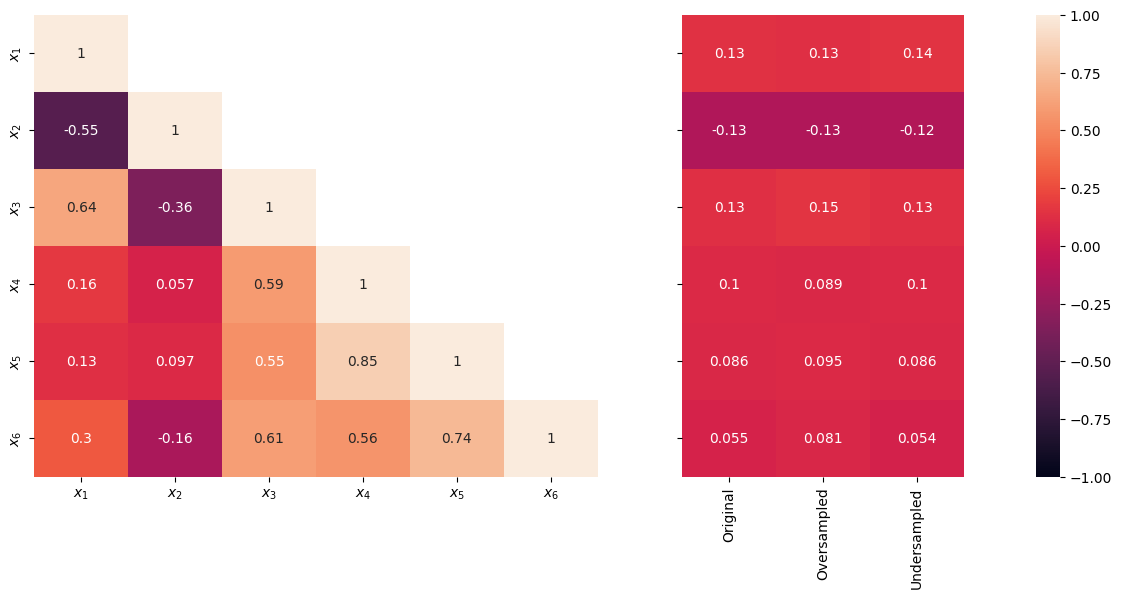

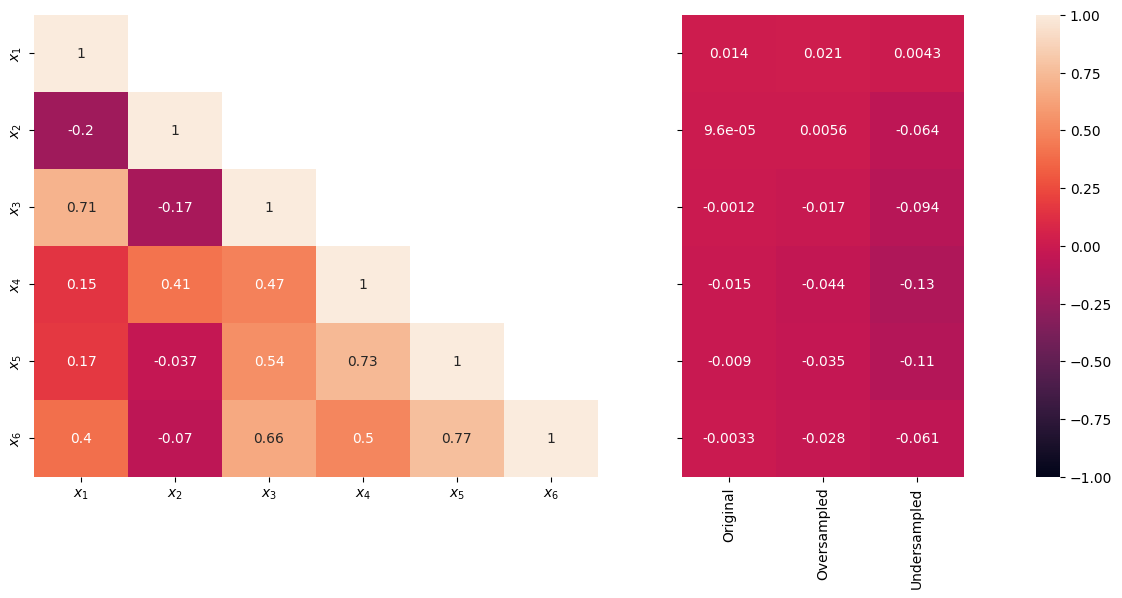

In [106]:
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_correlations(data, features, labels):
    """Calculate correlations between features and acceptance status."""
    correlations = []
    for feature in features:
        corr = np.corrcoef(data[feature], labels)[0, 1]
        correlations.append((feature, corr))
    return correlations

def calculate_correlations_with_sampling(features, labels, sampling_strategy='over'):
    """
    Calculate correlations with balanced sampling.
    
    Parameters:
    - features: DataFrame of features
    - labels: Array of binary labels
    - sampling_strategy: 'over' for oversampling minority class
                        'under' for undersampling majority class
    """
    # Combine features and labels
    data = features.copy()
    data['label'] = labels
    
    # Separate majority and minority classes
    majority_class = data[data.label == data.label.mode()[0]]
    minority_class = data[data.label != data.label.mode()[0]]
    
    if sampling_strategy == 'over':
        # Oversample minority class
        minority_upsampled = resample(minority_class,
                                    replace=True,
                                    n_samples=len(majority_class),
                                    random_state=42)
        balanced_data = pd.concat([majority_class, minority_upsampled])
    else:
        # Undersample majority class
        majority_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)
        balanced_data = pd.concat([majority_downsampled, minority_class])
    
    # Calculate correlations with balanced dataset
    correlations = []
    for feature in FEATURE_NAMES:
        corr = np.corrcoef(balanced_data[feature], balanced_data.label)[0, 1]
        correlations.append((feature, corr))
    
    return correlations

def plot_correlation_matrix(features):
    """Calculate and visualize the correlation matrix between features."""
    corr_matrix = np.zeros((len(FEATURE_NAMES), len(FEATURE_NAMES)))
    for i, name in enumerate(FEATURE_NAMES):
        for j, other_name in enumerate(FEATURE_NAMES):
            corr_matrix[i, j] = np.corrcoef(features[name], features[other_name])[0, 1]
    """
    # Print correlation matrix values
    print("\nCorrelation Matrix Values:")
    print("-------------------------")
    for i, name in enumerate(FEATURE_NAMES):
        row_values = [f"{corr_matrix[i, j]:.3f}" for j in range(len(FEATURE_NAMES))]
        print(f"{name:15} {' '.join(row_values)}")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix)
    plt.colorbar()
    label_font ={'family': 'serif','size': 16,}
    title_font ={'family': 'serif','size': 24,}
    plt.xticks(range(len(FEATURE_NAMES)), FEATURE_NAMES, fontdict=label_font)
    plt.yticks(range(len(FEATURE_NAMES)), FEATURE_NAMES, fontdict=label_font)
    plt.title('Feature Correlation Matrix', fontdict=title_font, y=1.05,x = (plt.gcf().subplotpars.right + plt.gcf().subplotpars.left)/2)
    plt.tight_layout()
    plt.show()
    """
    return corr_matrix

import seaborn as sns


# Calculate and display correlations for both conferences
for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    # Plot feature correlation matrix
    print(f"\n{conf_name} Feature Correlation Matrix:")
    corr_matrix = plot_correlation_matrix(features)

    # Calculate and display correlations with acceptance (original and balanced)
    print(f"\n{conf_name} Feature Correlations with Acceptance:")
    print("-" * 70)
    print(f"{'Feature':30} {'Original':>10} {'Oversampled':>15} {'Undersampled':>15}")
    print("-" * 70)

    fig,axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [2, 1]},sharey="all")
    fig.set_size_inches(12,6)   

    # Get correlations for all three approaches
    original_correlations = calculate_correlations(features, FEATURE_NAMES, labels)
    over_correlations = calculate_correlations_with_sampling(features, labels, 'over')
    under_correlations = calculate_correlations_with_sampling(features, labels, 'under')

    to_np_arr = lambda l : np.asarray([[e[1]] for e in l])

    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(corr_matrix)] = True
    mask[np.tril_indices_from(corr_matrix)] = False

    sns.heatmap(corr_matrix,yticklabels=FEATURE_NAMES,xticklabels=FEATURE_NAMES,mask=mask,ax=axs[0],annot=True,cbar=False,vmin=-1,vmax=1)
    sns.heatmap(np.concatenate([to_np_arr(original_correlations),to_np_arr(over_correlations),to_np_arr(under_correlations)],axis=-1),yticklabels=FEATURE_NAMES,xticklabels=["Original", "Oversampled", "Undersampled"],ax=axs[1],annot=True,vmin=-1,vmax=1,cbar_ax = fig.add_axes([0.96, 0.11, 0.02, 0.77]) )


    # Sort by absolute value of original correlation
    sorted_indices = [i for i, _ in sorted(enumerate(original_correlations), 
                                         key=lambda x: abs(x[1][1]), 
                                         reverse=True)]
    
    # Print comparative results
    for idx in sorted_indices:
        feature = FEATURE_NAMES[idx]
        print(f"{feature:30} {original_correlations[idx][1]:10.3f} "
              f"{over_correlations[idx][1]:15.3f} {under_correlations[idx][1]:15.3f}")

### ICLR Results
#### Correlations with Acceptance
- All correlations are very weak (|r| < 0.15) 
- Strongest positive correlations with Number of equations: 0.134 and overall unique symbols 0.128
- Mean number of new symbols introduced shows a negative correlation: -0.125
#### Correlations between features
- STRONG positive correlation between:
  - unique symbols and std of unique symbols: 0.85
  - Number of equations and overall unique symbols: 0.643
  - Max complexity and std of unique symbols: 0.741
- Notable negative correlation between num_equations and mean_num_new_symbols_introduced

### NeurIPS Results
#### Correlations with Acceptance
- Almost non-existent, practically zero. _Slightly_ stronger negative correlations in undersampled data.
#### Correlations between features
- STRONG positive correlation between:
  - Max complexity and std of unique symbols: 0.767
  - Number of equations and overall unqiue symbols: 0.706
  - Mean unique sumbols and std of unique symbols: 0.753
### Takeway
- Very weak evidence for hypothesis in ICLR, almost non-existent in NeurIPS, only appearing in undersampled data
  => Look at non-linear 
  => Try feature selection to avoid colinearity
- NeurIPS results will probably be plagued by the strong class imbalance, even if we undersample.

## Statistical Hypothesis Testing
- Multiple Tests to help us understand if there is statistically significant support for our hypothesis. Using Sampling strategies to combat class imbalances.
    - Student's t-test: Tests for differences in means, assuming equal variances.
    - Welch's t-test: A more robust version that doesn't assume equal variances.
    - Mann-Whitney U test: A non-parametric test that doesn't assume normal distribution.
    - Cohen's d: Measures the practical significance (effect size) of any differences. Inclues bootstrap confidence intervals to assess effect stability.


ICLR Statistical Analysis
+-----------+----------------------+---------------+-------------------------+-------------+----------+---------+--------+
| Feature   | Sample Sizes (A/R)   | Means (A/R)   | Cohen's d [95% CI]      | Effect      | t-test   | Welch   | M-W    |
+===========+======================+===============+=========================+=============+==========+=========+========+
| $X 1$     | 522/435              | 547.55/424.94 | 0.271 [0.147, 0.387]    | small†      | 0.000*   | 0.000*  | 0.000* |
+-----------+----------------------+---------------+-------------------------+-------------+----------+---------+--------+
| $X 2$     | 522/435              | 0.20/0.23     | -0.253 [-0.386, -0.125] | small†      | 0.000*   | 0.000*  | 0.000* |
+-----------+----------------------+---------------+-------------------------+-------------+----------+---------+--------+
| $X 3$     | 522/435              | 72.24/64.34   | 0.260 [0.142, 0.381]    | small†      | 0.000*   | 0.000*  

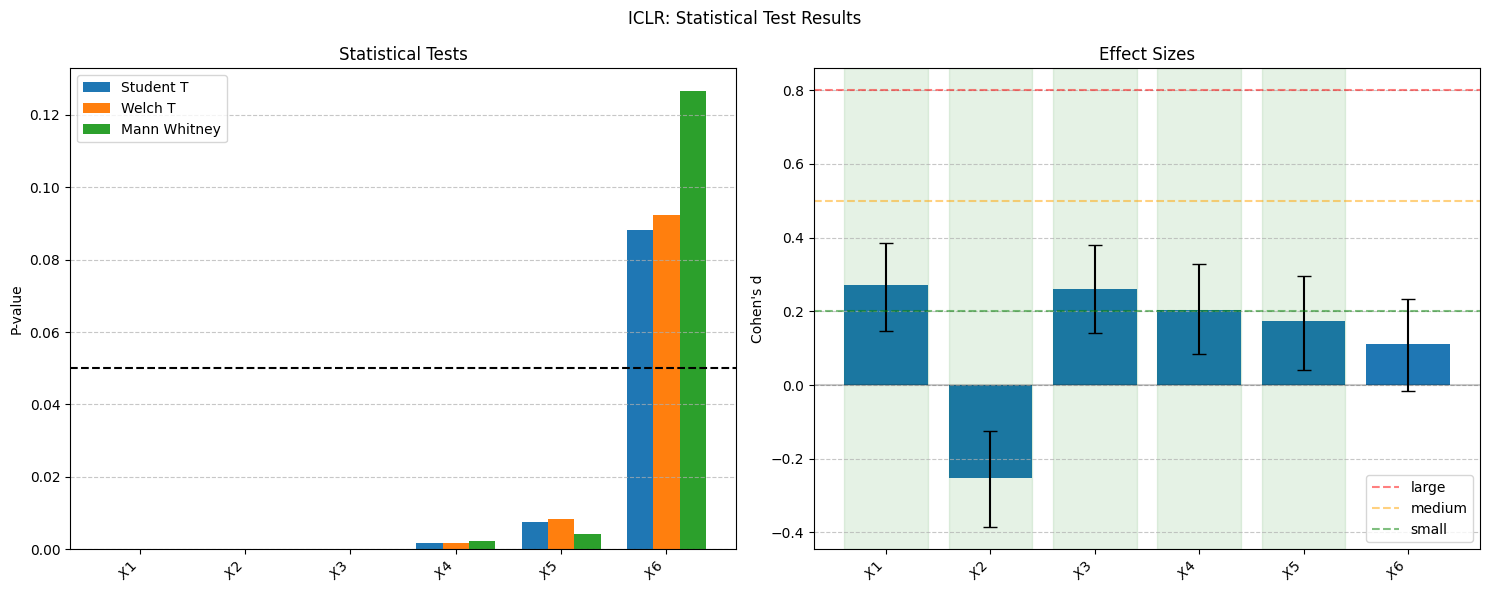


NeurIPS Statistical Analysis
+-----------+----------------------+---------------+------------------------+------------+----------+---------+-------+
| Feature   | Sample Sizes (A/R)   | Means (A/R)   | Cohen's d [95% CI]     | Effect     |   t-test |   Welch |   M-W |
+===========+======================+===============+========================+============+==========+=========+=======+
| $X 1$     | 2771/149             | 472.17/442.19 | 0.063 [-0.071, 0.185]  | negligible |    0.454 |   0.356 | 0.941 |
+-----------+----------------------+---------------+------------------------+------------+----------+---------+-------+
| $X 2$     | 2771/149             | 0.27/0.27     | 0.000 [-0.152, 0.078]  | negligible |    0.996 |   0.991 | 0.971 |
+-----------+----------------------+---------------+------------------------+------------+----------+---------+-------+
| $X 3$     | 2771/149             | 67.28/67.46   | -0.005 [-0.169, 0.144] | negligible |    0.949 |   0.945 | 0.585 |
+---------

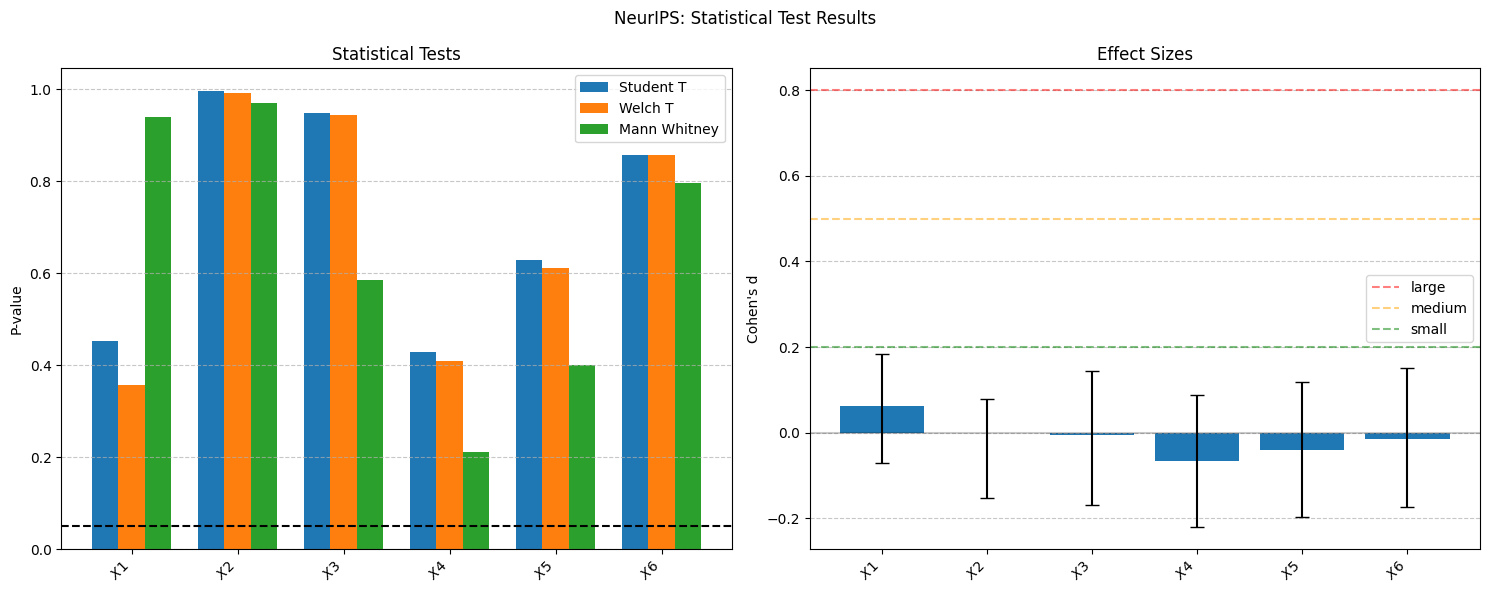

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate

def compare_means(sample1, sample2, feature_name, n_bootstrap=1000):
    """
    Perform comprehensive statistical comparison between two samples with
    bootstrap confidence intervals for effect sizes.
    
    Parameters:
    sample1, sample2: Arrays for accepted and rejected papers respectively
    feature_name: Name of the feature being analyzed
    n_bootstrap: Number of bootstrap iterations for confidence intervals
    
    Returns:
    Dictionary containing comprehensive statistical analysis results
    """
    # Calculate three different statistical tests to ensure robustness
    t_stat, t_pval = stats.ttest_ind(sample1, sample2)
    welch_stat, welch_pval = stats.ttest_ind(sample1, sample2, equal_var=False)
    mw_stat, mw_pval = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')
    
    # Calculate effect size (Cohen's d) with pooled standard deviation
    pooled_std = np.sqrt((np.var(sample1, ddof=1) * (len(sample1) - 1) + 
                         np.var(sample2, ddof=1) * (len(sample2) - 1)) / 
                        (len(sample1) + len(sample2) - 2))
    cohens_d = (np.mean(sample1) - np.mean(sample2)) / pooled_std
    
    # Bootstrap confidence intervals for effect size
    bootstrap_effects = []
    for _ in range(n_bootstrap):
        boot_s1 = np.random.choice(sample1, size=len(sample1), replace=True)
        boot_s2 = np.random.choice(sample2, size=len(sample2), replace=True)
        
        boot_std = np.sqrt((np.var(boot_s1, ddof=1) * (len(boot_s1) - 1) + 
                          np.var(boot_s2, ddof=1) * (len(boot_s2) - 1)) / 
                         (len(boot_s1) + len(boot_s2) - 2))
        boot_effect = (np.mean(boot_s1) - np.mean(boot_s2)) / boot_std
        bootstrap_effects.append(boot_effect)
    
    ci_lower, ci_upper = np.percentile(bootstrap_effects, [2.5, 97.5])
    
    # Interpret effect size magnitude
    if abs(cohens_d) < 0.2:
        effect_magnitude = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_magnitude = "small"
    elif abs(cohens_d) < 0.8:
        effect_magnitude = "medium"
    else:
        effect_magnitude = "large"
    
    return {
        "feature": feature_name,
        "sample_sizes": {
            "accepted": len(sample1),
            "rejected": len(sample2)
        },
        "means": {
            "accepted": np.mean(sample1),
            "rejected": np.mean(sample2)
        },
        "effect_size": {
            "cohens_d": cohens_d,
            "magnitude": effect_magnitude,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        },
        "tests": {
            "student_t": {
                "statistic": t_stat,
                "p_value": t_pval,
                "significant": t_pval < 0.05
            },
            "welch_t": {
                "statistic": welch_stat,
                "p_value": welch_pval,
                "significant": welch_pval < 0.05
            },
            "mann_whitney": {
                "statistic": mw_stat,
                "p_value": mw_pval,
                "significant": mw_pval < 0.05
            }
        }
    }

def create_analysis_table(results):
    """
    Create a formatted table showing statistical analysis results with confidence intervals
    and effect stability indicators.
    """
    headers = [
        "Feature", "Sample Sizes (A/R)", "Means (A/R)",
        "Cohen's d [95% CI]", "Effect", "t-test", "Welch", "M-W"
    ]
    
    table_data = []
    for feature, results in results.items():
        # Format various fields
        sizes = f"{results['sample_sizes']['accepted']}/{results['sample_sizes']['rejected']}"
        means = f"{results['means']['accepted']:.2f}/{results['means']['rejected']:.2f}"
        
        # Format effect size with CI
        effect_ci = f"{results['effect_size']['cohens_d']:.3f} [{results['effect_size']['ci_lower']:.3f}, {results['effect_size']['ci_upper']:.3f}]"
        
        # Check effect stability
        effect_stable = (results['effect_size']['ci_lower'] * results['effect_size']['ci_upper'] > 0)
        effect_magnitude = f"{results['effect_size']['magnitude']}{'†' if effect_stable else ''}"
        
        # Format p-values with significance markers
        def format_pval(test_result):
            return f"{test_result['p_value']:.3f}{'*' if test_result['significant'] else ''}"
        
        row = [
            feature.replace('_', ' ').title(),
            sizes,
            means,
            effect_ci,
            effect_magnitude,
            format_pval(results['tests']['student_t']),
            format_pval(results['tests']['welch_t']),
            format_pval(results['tests']['mann_whitney'])
        ]
        table_data.append(row)
    
    footnote = "\n† Effect direction is stable across bootstrap samples\n* p < 0.05"
    return tabulate(table_data, headers=headers, tablefmt='grid') + footnote

def plot_test_results(results, title):
    """
    Create visualization of statistical test results with confidence intervals
    and effect stability indicators.
    """
    features = list(results.keys())
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract data for plotting
    p_values = {test: [] for test in ['student_t', 'welch_t', 'mann_whitney']}
    effect_sizes = []
    ci_lower = []
    ci_upper = []
    
    for feature in features:
        for test in p_values.keys():
            p_values[test].append(results[feature]['tests'][test]['p_value'])
        effect_sizes.append(results[feature]['effect_size']['cohens_d'])
        ci_lower.append(results[feature]['effect_size']['ci_lower'])
        ci_upper.append(results[feature]['effect_size']['ci_upper'])
    
    # Plot p-values
    x = np.arange(len(features))
    width = 0.25
    
    for i, (test, vals) in enumerate(p_values.items()):
        ax1.bar(x + (i-1)*width, vals, width, label=test.replace('_', ' ').title())
    
    ax1.set_ylabel('P-value')
    ax1.set_title('Statistical Tests')
    ax1.set_xticks(x)
    ax1.set_xticklabels([feat.replace('_', ' ').title() for feat in features], 
                        rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax1.axhline(0.05, linestyle="--", color="black", label="significance")
    
    # Plot effect sizes with confidence intervals
    ax2.bar(x, effect_sizes)
    ax2.errorbar(x, effect_sizes, 
                yerr=[np.array(effect_sizes) - np.array(ci_lower), 
                      np.array(ci_upper) - np.array(effect_sizes)],
                fmt='none', color='black', capsize=5)
    
    ax2.set_ylabel("Cohen's d")
    ax2.set_title('Effect Sizes')
    ax2.set_xticks(x)
    ax2.set_xticklabels([feat.replace('_', ' ').title() for feat in features], 
                        rotation=45, ha='right')
    ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add reference lines and highlight stable effects
    ax2.axhline(0, color='black', linestyle='-', alpha=0.2)
    ax2.axhline(0.8, linestyle="--", color="red", alpha=0.5, label="large")
    ax2.axhline(0.5, linestyle="--", color="orange", alpha=0.5, label="medium")
    ax2.axhline(0.2, linestyle="--", color="green", alpha=0.5, label="small")
    ax2.legend()
    
    # Highlight stable effects
    for i, (lower, upper) in enumerate(zip(ci_lower, ci_upper)):
        if lower * upper > 0:  # Same sign means stable effect
            ax2.axvspan(i-0.4, i+0.4, alpha=0.1, color='green')
    
    plt.suptitle(title)
    plt.tight_layout()
    return fig

# Perform analysis for both conferences
for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    print(f"\n{'='*50}")
    print(f"{conf_name} Statistical Analysis")
    print(f"{'='*50}")
    
    # Store results for all features
    all_results = {}
    
    for feature in FEATURE_NAMES:
        feature_data = features[feature]
        accepted = feature_data[labels == 1]
        rejected = feature_data[labels == 0]
        
        # Analyze each feature
        results = compare_means(accepted, rejected, feature)
        all_results[feature] = results
    
    # Print table of results
    print(create_analysis_table(all_results))
    
    # Calculate summary statistics
    sig_effects = sum(1 for feature in all_results if all(
        all_results[feature]['tests'][test]['significant']
        for test in ['student_t', 'welch_t', 'mann_whitney']
    ))
    
    stable_effects = sum(1 for feature in all_results if 
        all_results[feature]['effect_size']['ci_lower'] * 
        all_results[feature]['effect_size']['ci_upper'] > 0
    )
    
    print(f"\nSummary:")
    print(f"Features with significant effects: {sig_effects}/{len(all_results)}")
    print(f"Features with stable effects: {stable_effects}/{len(all_results)}")
    
    # Visualize results
    fig = plot_test_results(all_results, f'{conf_name}: Statistical Test Results')
    plt.show()

### ICLR Results
- Significant results in 5/6 features across all three tests. Stable across bootstrap samples.Impact is modest. 
    - Number of equations shows the strongest effect (d = 0.271, p < 0.001)
    - Mean new symbols introduced shows a negative effet (d = -0.253, p < 0.001)
    - Number of overall unique symbols shows a positive effect (d=0.260, p < 0.001)
    - Mean unique symbols shows a small positive effect (d= 0.205, p = 0.002)
    - Standard deviation of unique symbols shows a negligible effect (d= 0.174, p=0.008)
    - Max representational complexity shows no significant effect (d=0.111, p=0.088)

### Takeway
- For ICLR there actually seems to be a statistically significant, but small effect for our hypothesis that's stable across different tests!

## Two-way ANOVA and Interaction Analysis
- Conducted two-way ANOVA analysis to examine how mathematical complexity features interact in influencing paper acceptance
- Key methodological components:
   1. Comprehensive pairwise testing of all feature combinations
   2. F-statistics and p-values to quantify interaction strength
   3. Quartile binning of features to analyze non-linear effects with relative acceptance rate changes from baseline and statistical significance


ICLR INTERACTION ANALYSIS



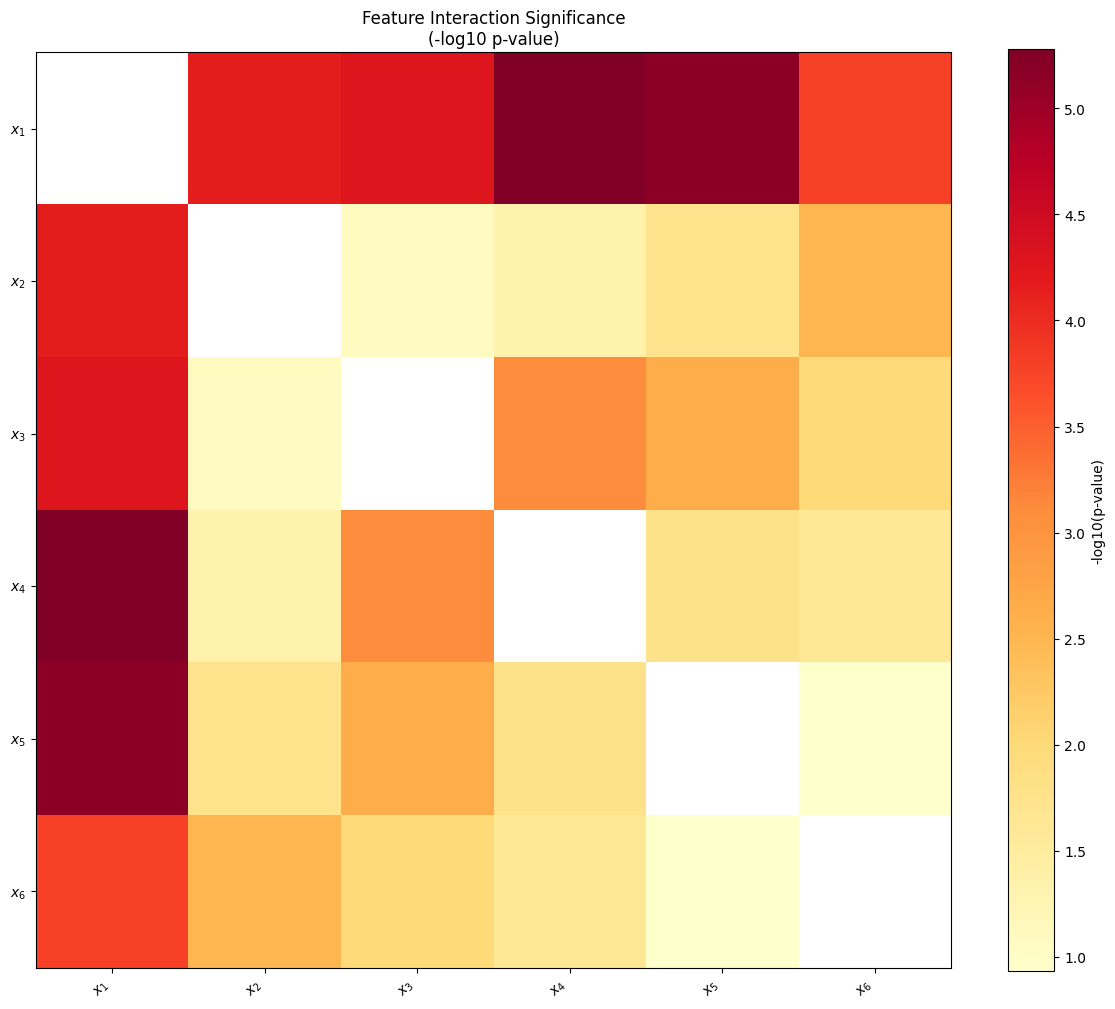

FEATURE INTERACTION ANALYSIS SUMMARY
Total number of papers: 957
Overall acceptance rate: 54.55%
Number of significant interactions: 13

SIGNIFICANT INTERACTIONS OVERVIEW:
+----------------+---------------+-----------+
| Feature Pair   |   F-statistic |   p-value |
+================+===============+===========+
| $x_1$ × $x_4$  |        20.98  | 5.255e-06 |
+----------------+---------------+-----------+
| $x_1$ × $x_5$  |        20.411 | 7.029e-06 |
+----------------+---------------+-----------+
| $x_1$ × $x_3$  |        16.487 | 5.301e-05 |
+----------------+---------------+-----------+
| $x_1$ × $x_2$  |        16.026 | 6.731e-05 |
+----------------+---------------+-----------+
| $x_1$ × $x_6$  |        14.267 | 0.0001684 |
+----------------+---------------+-----------+
| $x_3$ × $x_4$  |        11.309 | 0.0008021 |
+----------------+---------------+-----------+
| $x_3$ × $x_5$  |         9.267 | 0.002397  |
+----------------+---------------+-----------+
| $x_2$ × $x_6$  |         8.

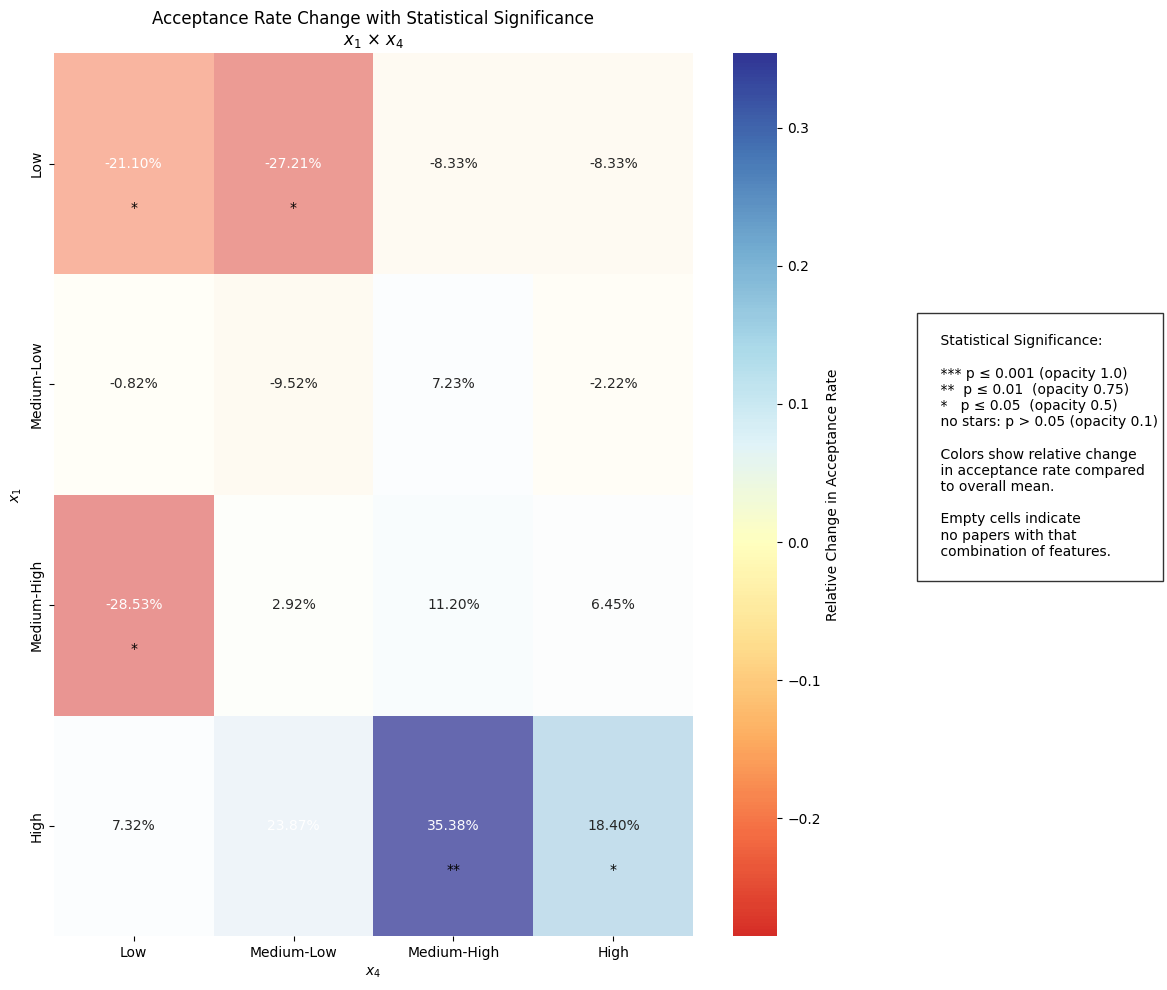

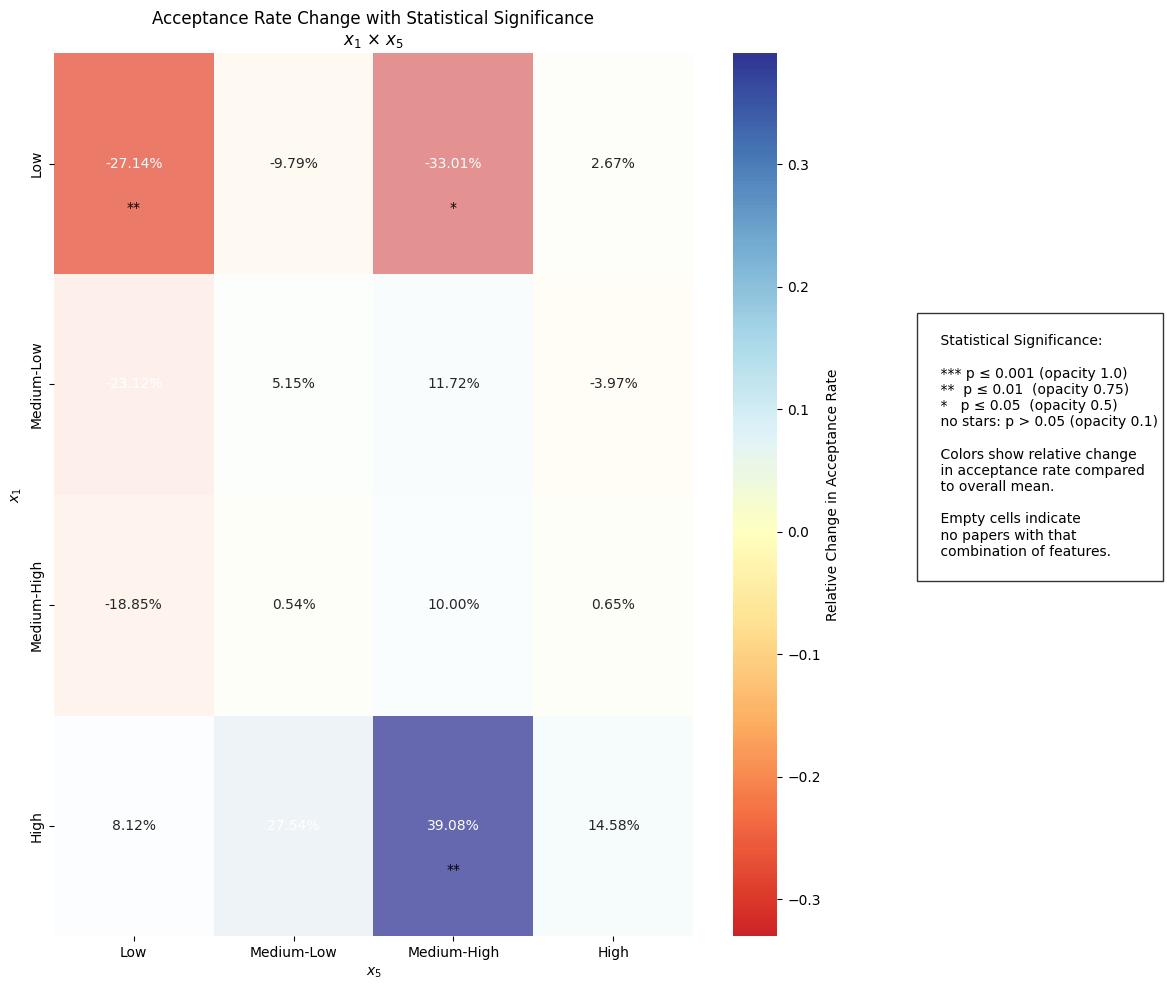

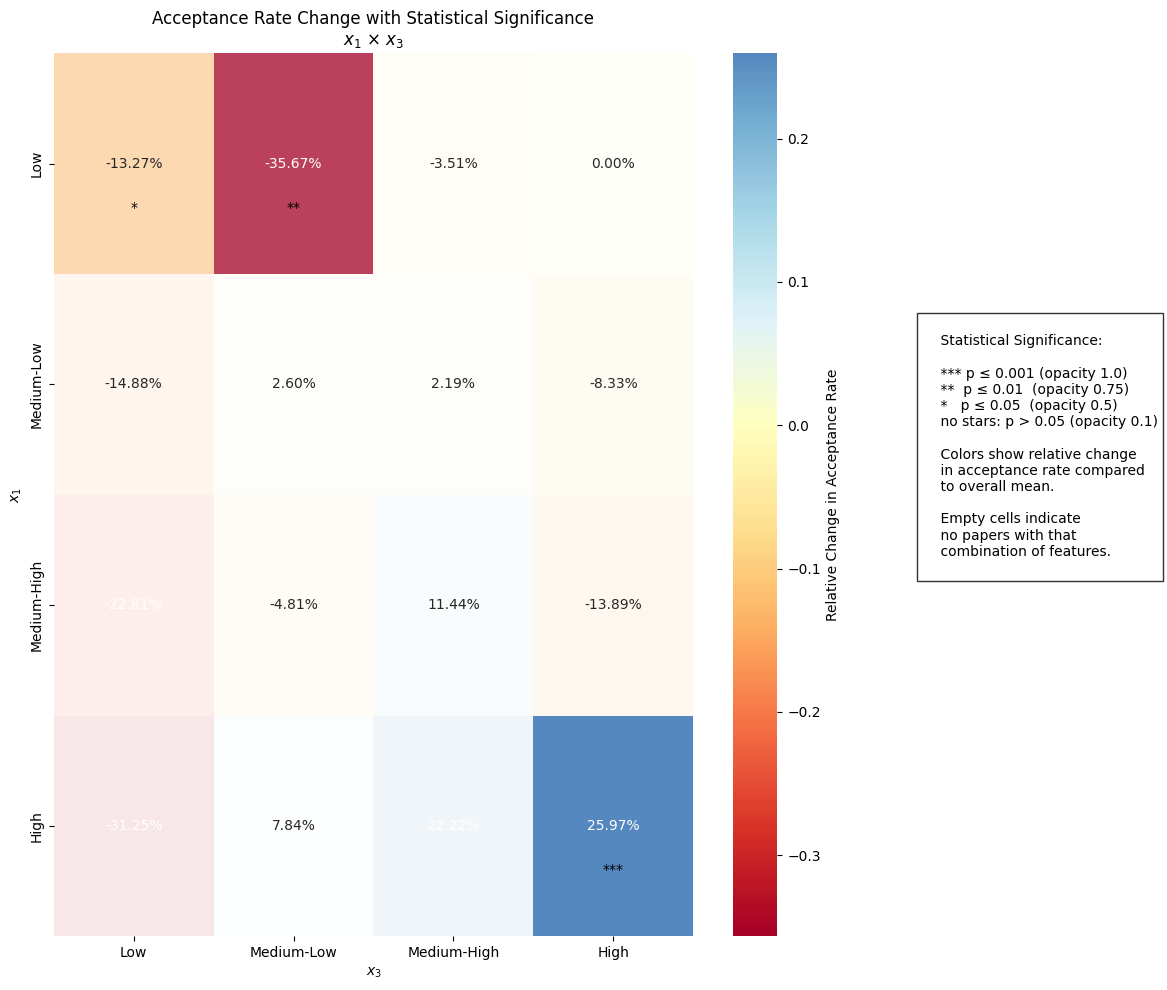

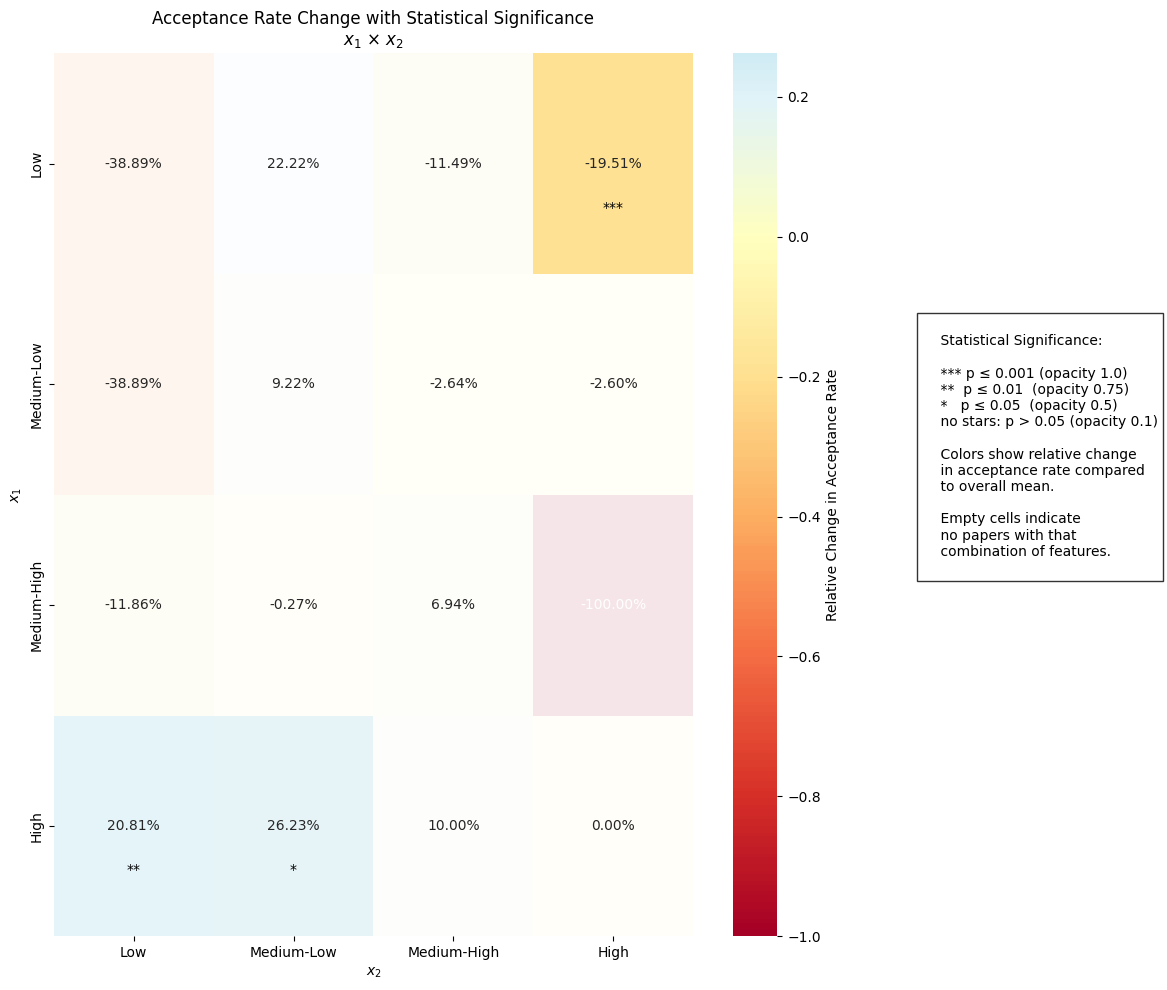

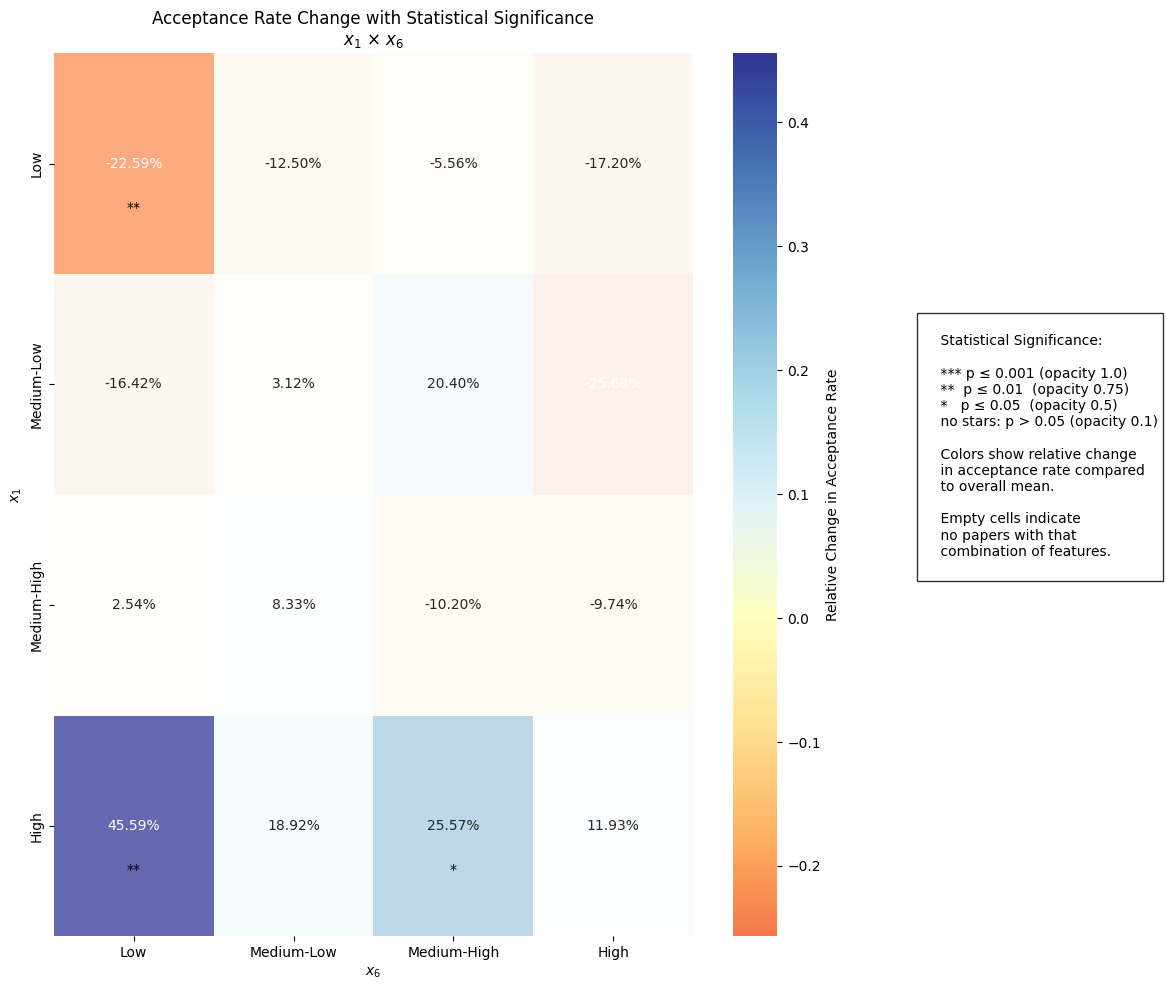

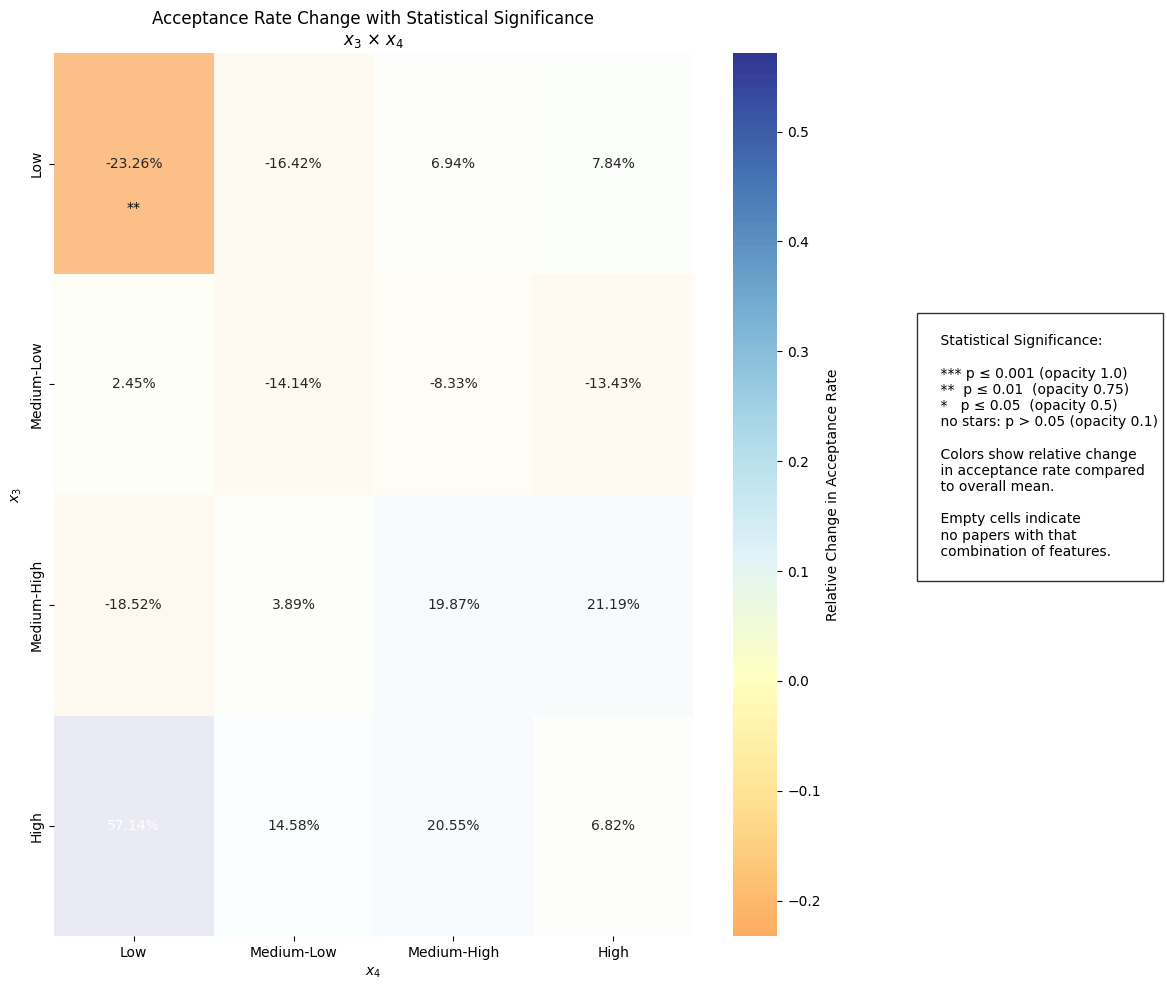

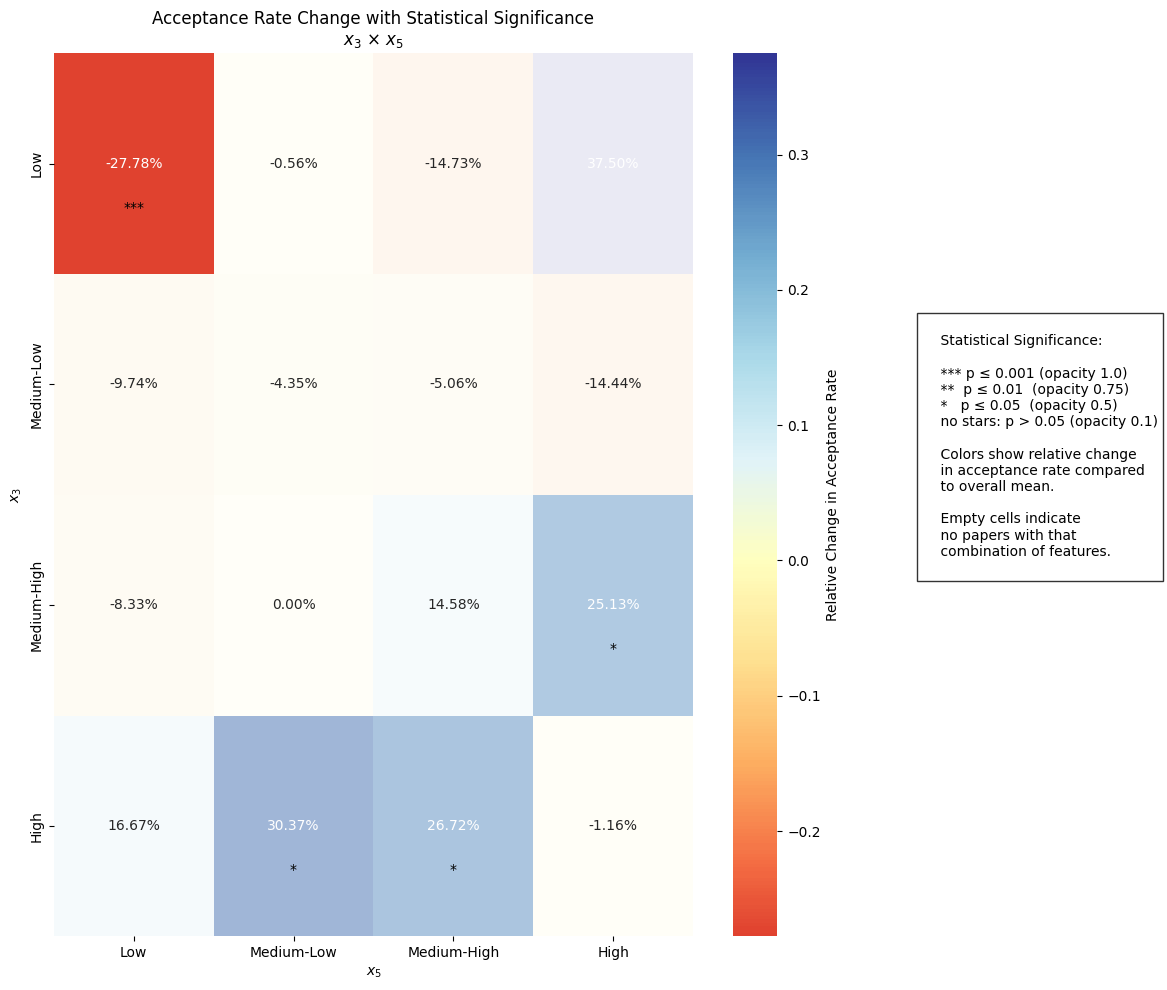

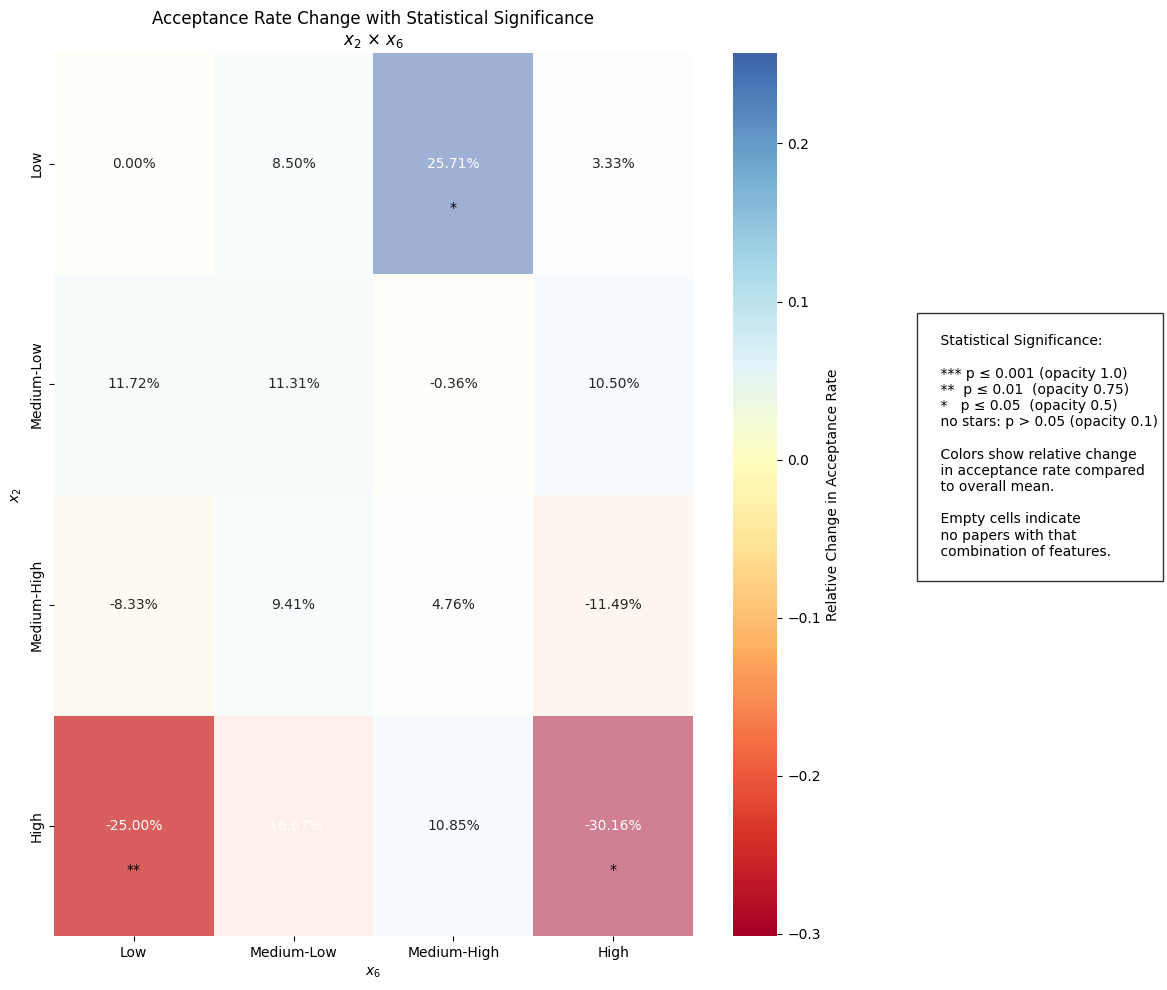

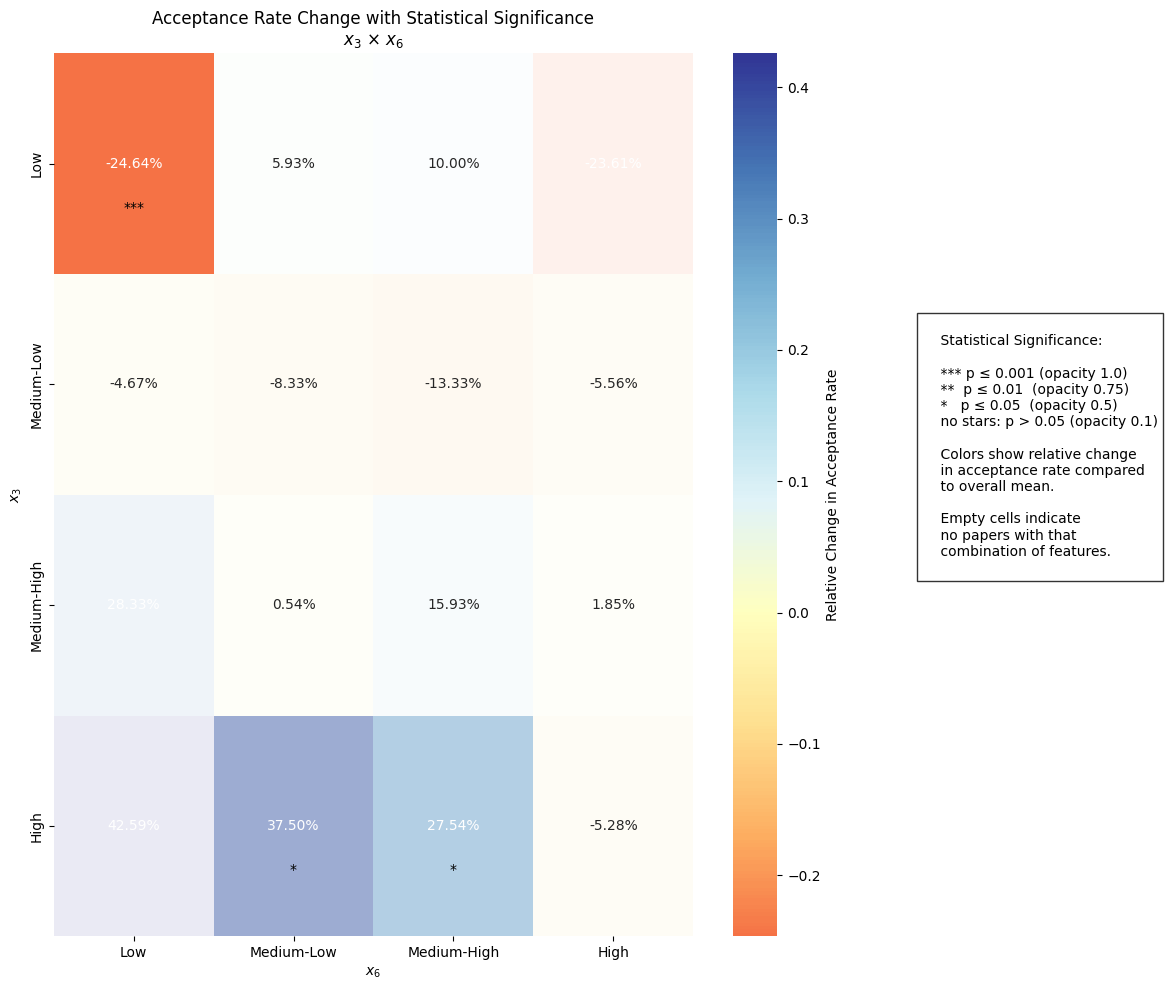

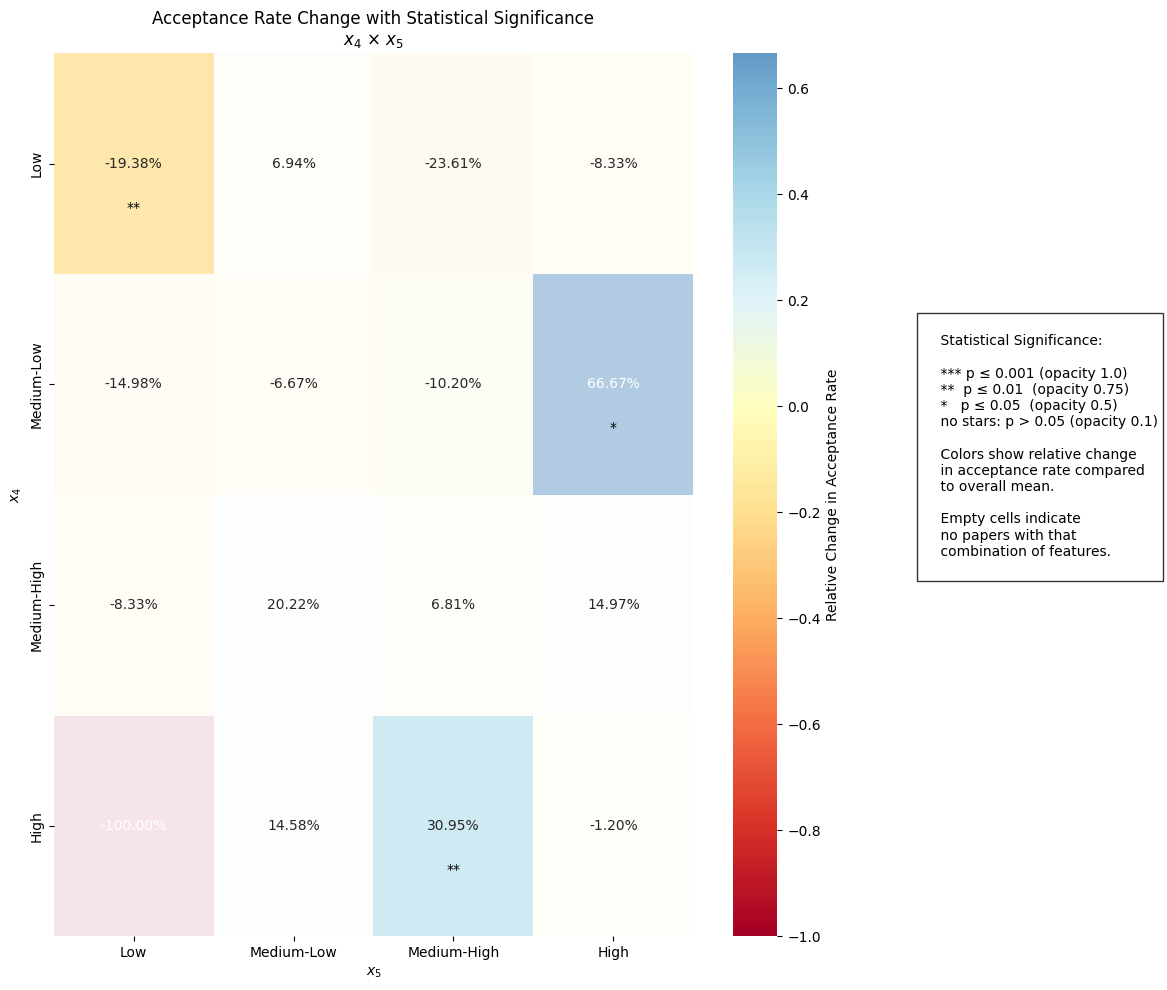

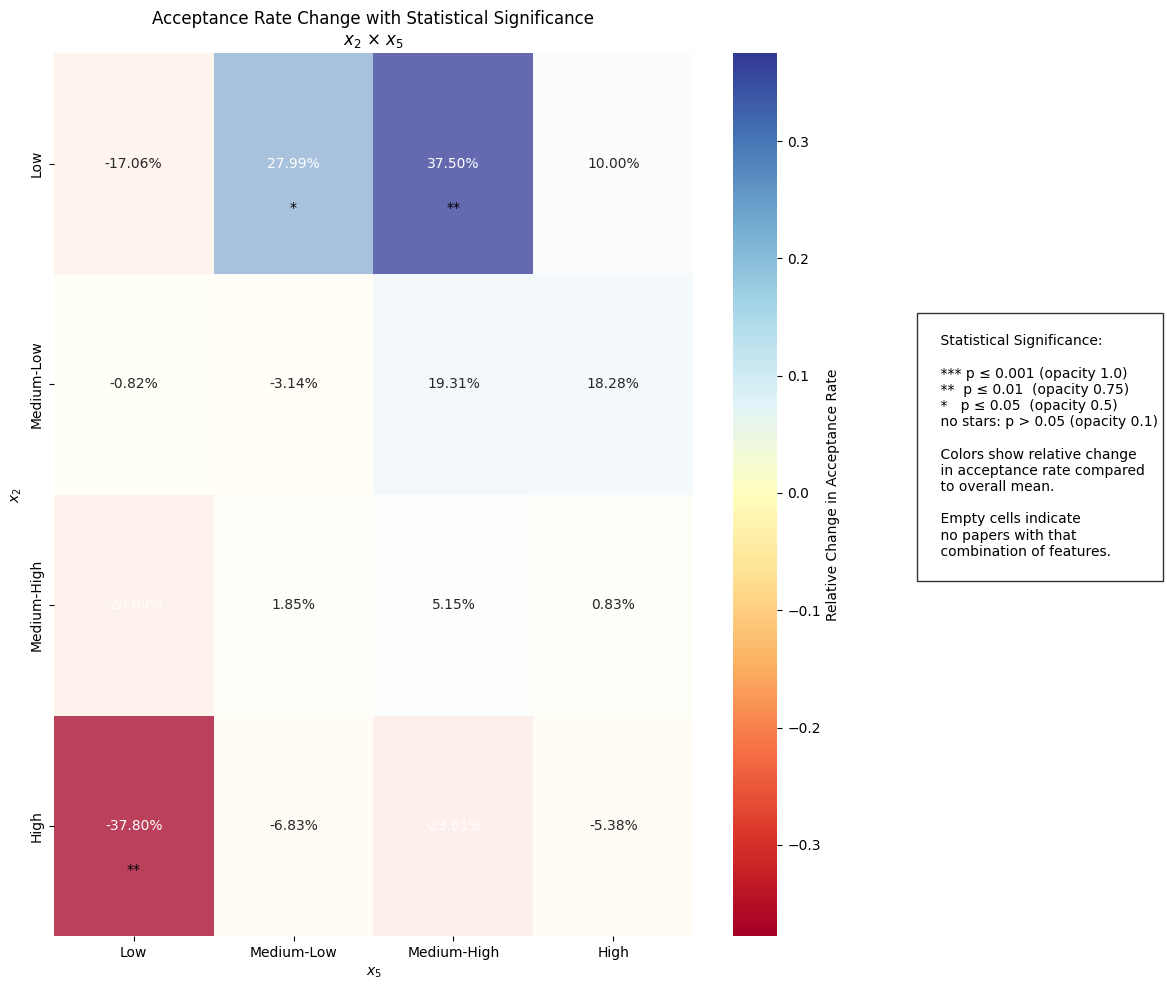

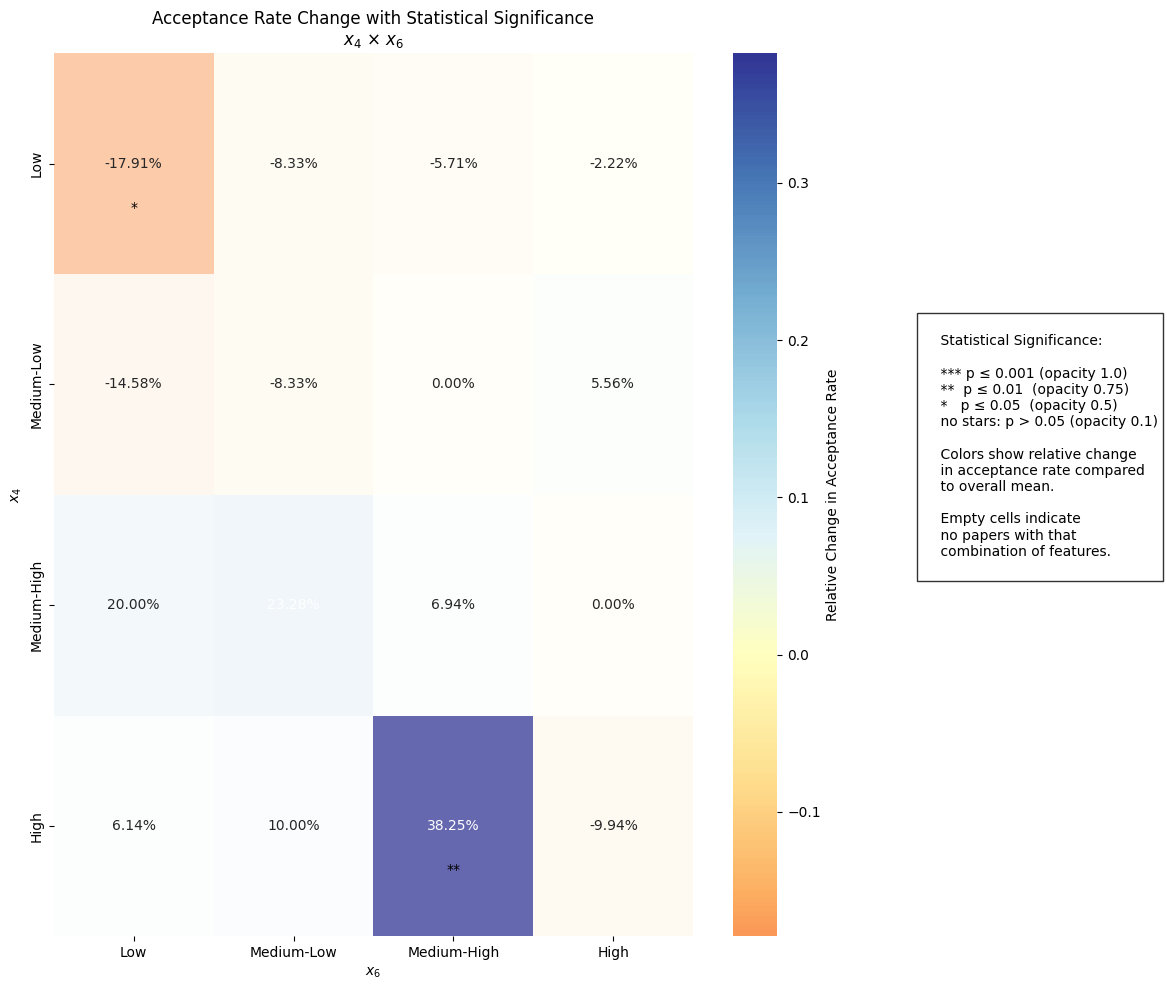

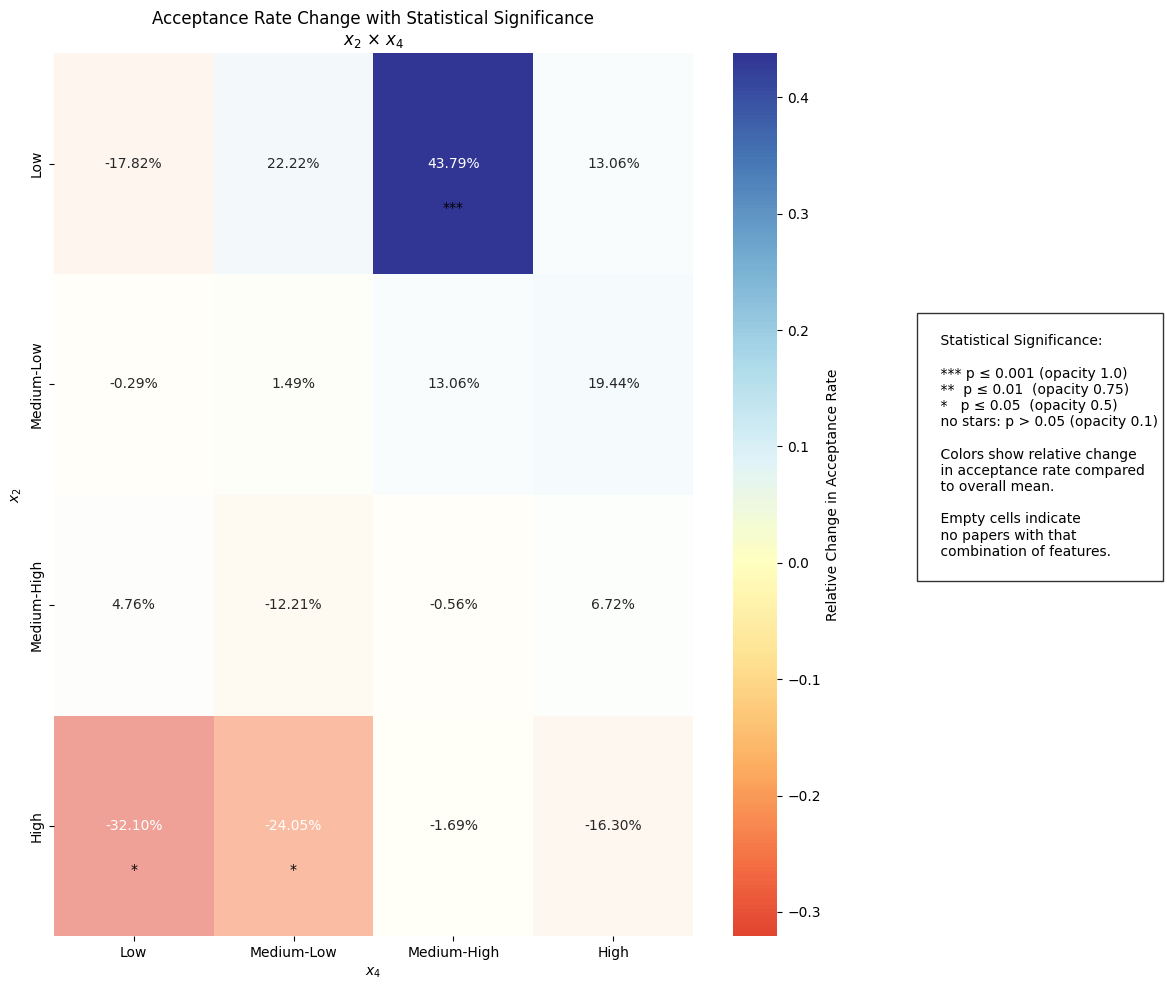

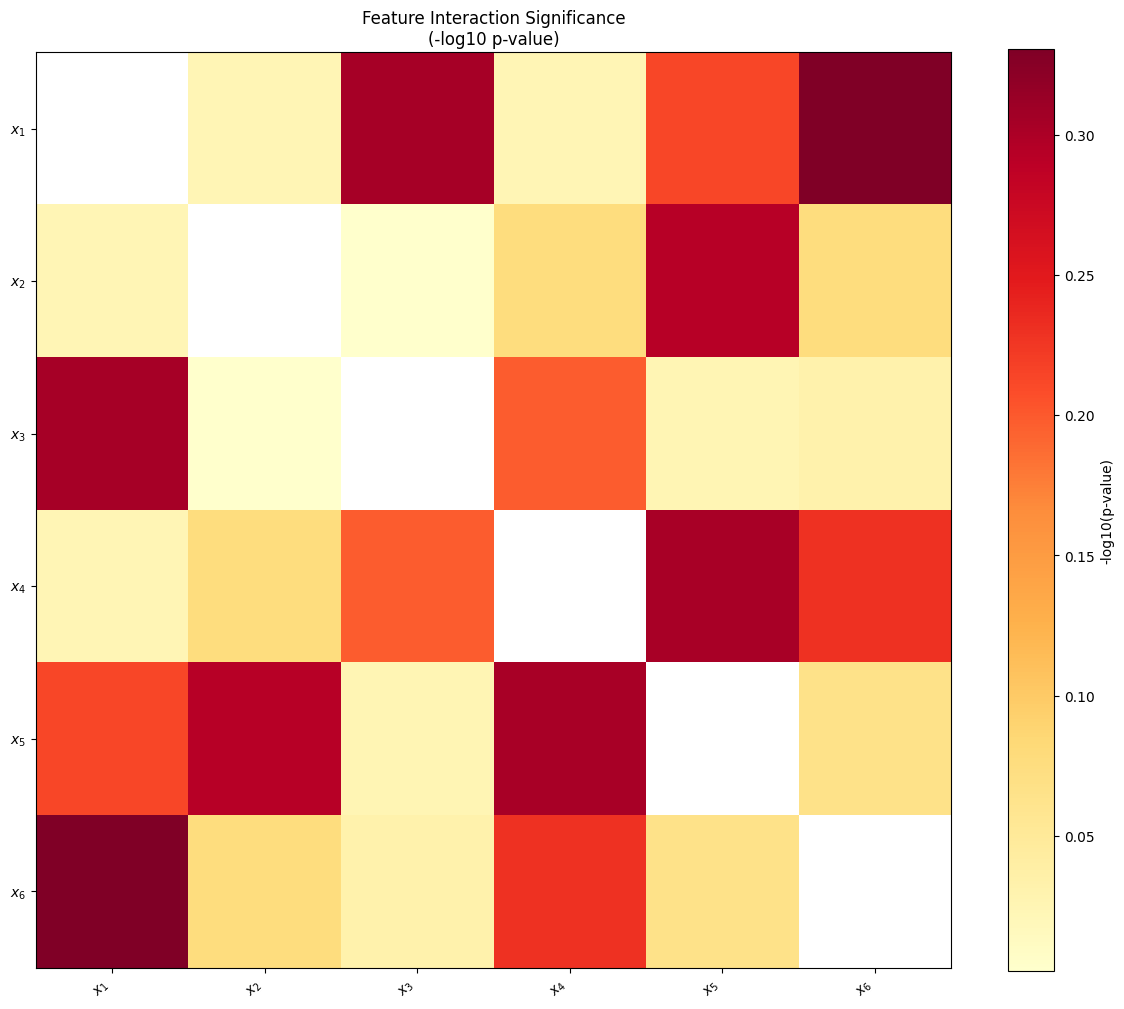

FEATURE INTERACTION ANALYSIS SUMMARY
Total number of papers: 2920
Overall acceptance rate: 94.90%
Number of significant interactions: 0

No significant interactions found.



In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, fisher_exact, chi2_contingency

def perform_anova_analysis(data, labels, feature_names):
    """
    Perform two-way ANOVA analysis to identify significant feature interactions.
    Returns interactions sorted by significance for further detailed analysis.
    """
    interactions = []
    p_values = np.zeros((len(feature_names), len(feature_names)))
    f_stats = np.zeros((len(feature_names), len(feature_names)))
    
    # Analyze all possible feature pairs
    for i, feat1 in enumerate(feature_names):
        for j, feat2 in enumerate(feature_names):
            if i < j:  # Only compute upper triangle to avoid redundancy
                interaction = data[feat1] * data[feat2]
                accepted_inter = interaction[labels == 1]
                rejected_inter = interaction[labels == 0]
                
                f_stat, p_val = f_oneway(accepted_inter, rejected_inter)
                
                # Store results for visualization and sorting
                p_values[i, j] = p_val
                p_values[j, i] = p_val
                f_stats[i, j] = f_stat
                f_stats[j, i] = f_stat
                
                interactions.append({
                    'features': (feat1, feat2),
                    'f_statistic': f_stat,
                    'p_value': p_val
                })
    
    # Visualize overall interaction significance
    plt.figure(figsize=(12, 10))
    plt.imshow(-np.log10(p_values), cmap='YlOrRd')
    plt.colorbar(label='-log10(p-value)')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Feature Interaction Significance\n(-log10 p-value)')
    plt.tight_layout()
    plt.show()
    
    # Sort interactions by significance
    return sorted(interactions, key=lambda x: x['p_value'])

def analyze_feature_interaction(data, labels, feature1, feature2):
    """
    Analyze feature interactions with statistical significance testing for each combination.
    Shows all combinations with varying opacity and includes a detailed legend.
    
    Parameters:
    data: DataFrame containing the features
    labels: Binary acceptance labels
    feature1, feature2: Names of features to analyze
    """
    # Create quartile bins for both features
    q1 = pd.qcut(data[feature1], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    q2 = pd.qcut(data[feature2], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Initialize our measurement matrices
    acceptance_matrix = pd.DataFrame(
        np.zeros((4, 4)),
        index=['Low', 'Medium-Low', 'Medium-High', 'High'],
        columns=['Low', 'Medium-Low', 'Medium-High', 'High']
    )
    
    p_value_matrix = pd.DataFrame(
        np.ones((4, 4)),
        index=acceptance_matrix.index,
        columns=acceptance_matrix.columns
    )
    
    sample_size_matrix = pd.DataFrame(
        np.zeros((4, 4)),
        index=acceptance_matrix.index,
        columns=acceptance_matrix.columns
    )
    
    mean_acceptance = np.mean(labels)
    
    # Calculate statistics for each combination
    for i in acceptance_matrix.index:
        for j in acceptance_matrix.columns:
            mask = (q1 == i) & (q2 == j)
            cell_size = sum(mask)
            sample_size_matrix.loc[i, j] = cell_size
            
            if cell_size > 0:
                # Calculate relative acceptance rate
                acceptance_rate = np.mean(labels[mask])
                acceptance_matrix.loc[i, j] = acceptance_rate / mean_acceptance - 1
                
                # Perform statistical test
                accepted_in_cell = sum(labels[mask])
                rejected_in_cell = cell_size - accepted_in_cell
                accepted_others = sum(labels[~mask])
                rejected_others = sum(~mask) - accepted_others
                
                contingency_table = [[accepted_in_cell, rejected_in_cell],
                                   [accepted_others, rejected_others]]
                
                if cell_size < 30:
                    _, p_value = fisher_exact(contingency_table)
                else:
                    _, p_value, _, _ = chi2_contingency(contingency_table)
                
                p_value_matrix.loc[i, j] = p_value
    
    # Create figure with main heatmap and legend
    fig = plt.figure(figsize=(12, 10))
    
    # Create main axes for heatmap
    ax_heatmap = plt.subplot2grid((1, 20), (0, 0), colspan=15)
    
    # Calculate opacity based on statistical significance
    # Now using a more gradual scale that shows all results
    opacity_matrix = np.where(
        p_value_matrix <= 0.001, 1.0,
        np.where(p_value_matrix <= 0.01, 0.75,
        np.where(p_value_matrix <= 0.05, 0.5,
        0.1)))  # Very faint but visible for non-significant results
    
    # Create the heatmap
    sns.heatmap(acceptance_matrix,
                annot=True,
                fmt='.2%',
                cmap='RdYlBu',
                center=0,
                alpha=opacity_matrix,
                cbar_kws={'label': 'Relative Change in Acceptance Rate'},
                ax=ax_heatmap)
    
    # Add significance markers
    for i in range(4):
        for j in range(4):
            if sample_size_matrix.iloc[i, j] > 0:  # Only add markers where we have data
                significance = ''
                if p_value_matrix.iloc[i, j] <= 0.001:
                    significance = '***'
                elif p_value_matrix.iloc[i, j] <= 0.01:
                    significance = '**'
                elif p_value_matrix.iloc[i, j] <= 0.05:
                    significance = '*'
                ax_heatmap.text(j + 0.5, i + 0.7, significance,
                              ha='center', va='center',
                              color='black')
    
    ax_heatmap.set_title(f'Acceptance Rate Change with Statistical Significance\n{feature1} × {feature2}')
    ax_heatmap.set_xlabel(feature2)
    ax_heatmap.set_ylabel(feature1)
    
    # Create legend axes
    ax_legend = plt.subplot2grid((1, 20), (0, 16), colspan=4)
    ax_legend.axis('off')
    
    # Add legend text
    legend_text = """
    Statistical Significance:
    
    *** p ≤ 0.001 (opacity 1.0)
    **  p ≤ 0.01  (opacity 0.75)
    *   p ≤ 0.05  (opacity 0.5)
    no stars: p > 0.05 (opacity 0.1)
    
    Colors show relative change
    in acceptance rate compared
    to overall mean.
    
    Empty cells indicate
    no papers with that
    combination of features.
    """
    ax_legend.text(0, 0.7, legend_text,
                  fontsize=10,
                  verticalalignment='top',
                  bbox=dict(facecolor='white',
                           edgecolor='black',
                           alpha=0.8))
    
    plt.tight_layout()
    return acceptance_matrix, p_value_matrix, sample_size_matrix

def analyze_significant_interactions(data, labels, feature_names, p_value_threshold=0.05):
    """
    Perform comprehensive interaction analysis by combining ANOVA and detailed visualization
    for all significant feature pairs.
    """
    # First, identify significant interactions using ANOVA
    print("Performing initial ANOVA analysis...")
    interactions = perform_anova_analysis(data, labels, feature_names)
    
    # Filter significant interactions
    significant_interactions = [x for x in interactions if x['p_value'] < p_value_threshold]
    
    print(f"\nFound {len(significant_interactions)} significant interactions (p < {p_value_threshold})")
    
    # Analyze each significant interaction in detail
    for interaction in significant_interactions:
        feat1, feat2 = interaction['features']
        print(f"\nAnalyzing interaction: {feat1} × {feat2}")
        print(f"F-statistic: {interaction['f_statistic']:.3f}")
        print(f"p-value: {interaction['p_value']:.3e}")
        
        # Perform detailed analysis of the interaction
        acc_matrix, p_value_matrix, sample_size_matrix = analyze_feature_interaction(
            data, labels, feat1, feat2
        )

def analyze_interactions(data, labels, feature_names, p_value_threshold=0.05):
    """
    Generate a comprehensive tabular summary of feature interactions and their statistical significance.
    Returns a formatted string containing all relevant information in an easily parseable format.
    """
    from tabulate import tabulate
    
    # First, perform ANOVA analysis
    interactions = perform_anova_analysis(data, labels, feature_names)
    significant_interactions = [x for x in interactions if x['p_value'] < p_value_threshold]
    
    # Initialize our summary string
    summary = f"FEATURE INTERACTION ANALYSIS SUMMARY\n"
    summary += f"Total number of papers: {len(labels)}\n"
    summary += f"Overall acceptance rate: {np.mean(labels)*100:.2f}%\n"
    summary += f"Number of significant interactions: {len(significant_interactions)}\n\n"
    
    if len(significant_interactions) == 0:
        summary += "No significant interactions found.\n"
        return summary
    
    # Create a summary table of significant interactions
    interaction_table = []
    for interaction in significant_interactions:
        feat1, feat2 = interaction['features']
        interaction_table.append([
            f"{feat1} × {feat2}",
            f"{interaction['f_statistic']:.3f}",
            f"{interaction['p_value']:.3e}"
        ])
    
    summary += "SIGNIFICANT INTERACTIONS OVERVIEW:\n"
    summary += tabulate(interaction_table,
                       headers=['Feature Pair', 'F-statistic', 'p-value'],
                       tablefmt='grid') + "\n\n"
    
    # For each significant interaction, perform detailed analysis
    for interaction in significant_interactions:
        feat1, feat2 = interaction['features']
        acc_matrix, p_value_matrix, sample_size_matrix = analyze_feature_interaction(
            data, labels, feat1, feat2
        )
        
        summary += f"DETAILED ANALYSIS: {feat1} × {feat2}\n"
        summary += f"F-statistic: {interaction['f_statistic']:.3f}, p-value: {interaction['p_value']:.3e}\n\n"
        
        # Create a combined matrix for display
        combined_matrix = []
        for i in acc_matrix.index:
            for j in acc_matrix.columns:
                # Format significance stars
                significance = ''
                if p_value_matrix.loc[i, j] <= 0.001:
                    significance = '***'
                elif p_value_matrix.loc[i, j] <= 0.01:
                    significance = '**'
                elif p_value_matrix.loc[i, j] <= 0.05:
                    significance = '*'
                
                # Only include combinations where we have data
                if sample_size_matrix.loc[i, j] > 0:
                    combined_matrix.append([
                        i,  # First feature level
                        j,  # Second feature level
                        f"{acc_matrix.loc[i, j]*100:+.2f}%",  # Relative acceptance rate change
                        int(sample_size_matrix.loc[i, j]),  # Sample size
                        f"{p_value_matrix.loc[i, j]:.3e}",  # p-value
                        significance  # Significance stars
                    ])
        
        summary += "Detailed Statistics by Feature Combination:\n"
        summary += tabulate(combined_matrix,
                          headers=[f'{feat1} Level', 
                                 f'{feat2} Level',
                                 'Rel. Acceptance Δ',
                                 'Sample Size',
                                 'p-value',
                                 'Significance'],
                          tablefmt='grid') + "\n\n"
        
        summary += "Significance levels: *** p≤0.001, ** p≤0.01, * p≤0.05\n"
        summary += "Relative Acceptance Δ shows percentage change from mean acceptance rate\n\n"
        summary += "-" * 80 + "\n\n"
    
    return summary

# Run the analysis for both conferences
for conf_name, features, labels in [('ICLR', iclr_features, iclr_labels),
                                  ('NeurIPS', neurips_features, neurips_labels)]:
    print(f"\n{'='*80}")
    print(f"{conf_name} INTERACTION ANALYSIS")
    print(f"{'='*80}\n")
    
    summary = analyze_interactions(features, labels, FEATURE_NAMES)
    print(summary)

### ICLR Results
1. Primary Interactions with Number of Equations (Strongest Effects)
  - Mean number of unique symbols (F=20.980, p=5.255e-06)
    * High/High combination: +35.38% acceptance rate
    * Low/Low combination: -27.21% acceptance rate
  - Std of unique symbols (F=20.411, p=7.029e-06)
    * High/High combination: +39.08% acceptance rate
    * Low/Low combination: -27.14% acceptance rate
  - Number of overall unique symbols (F=16.487, p=5.301e-05)
    * High/High combination: +25.97% acceptance rate
    * Low/Medium-Low combination: -35.67% acceptance rate
  - Mean number of new symbols introduced (F=16.026, p=6.731e-05)
    * High equation count/Low new symbols: +20.81% acceptance rate
    * Low equation count/High new symbols: -19.51% acceptance rate
  - Max representational complexity (F=14.267, p=1.684e-04)
    * High/High combination: +11.93% acceptance rate
    * Low/Low combination: -22.59% acceptance rate

2. Secondary Interactions with Overall Unique Symbols
  - Mean number of unique symbols (F=11.309, p=8.021e-04)
  - Standard deviation of unique symbols (F=9.267, p=2.397e-03)
  - Max representational complexity (F=6.647, p=1.008e-02)

3. Symbol Introduction and Complexity Interactions
  - With max representational complexity (F=8.779, p=3.123e-03)
  - With std of unique symbols (F=5.581, p=1.836e-02)
  - With mean number of unique symbols (F=3.969, p=4.664e-02)


### Takeway
1. Reinforces correlation analysis:
  - Confirms importance of equation count
  - Shows why correlations were modest - effects are non-linear and dependent on other features

2. Extends statistical testing:
  - Reveals why some features showed small individual effects
  - Demonstrates importance of feature combinations

3. Mathematical Complexity Patterns for Success:
  - High equation count WITH consistent symbol usage
  - Systematic mathematical development
  - Limited notation introduction
  - Comprehensive but controlled complexity


## Machine Learning Analysis
- Trained a diversity of ML models to predict acceptance based on math complexity. We did different models  so we weren't missing potential patterns only specific algorithms might caputure.
- Used multiple performance metrics to get a complete picture of model performance.
- Compared model performance to baseline

#### Model Selection Strategy
- **Logistic Regression**
 * Linear model that assumes direct feature-to-outcome relationships
 * Pros: Interpretable, stable, reveals linear patterns
 * Cons: Cannot capture complex non-linear relationships
 * Purpose: Baseline for detecting straightforward mathematical complexity effects

- **Random Forest**
 * Ensemble of decision trees that capture non-linear patterns and interactions
 * Pros: Can model complex feature relationships, handles outliers well
 * Cons: Less interpretable than linear models
 * Purpose: Detect potential non-linear patterns missed by logistic regression

- **SVM with RBF Kernel**
 * Non-linear classifier that maps features to higher dimensions
 * Pros: Excellent at finding complex decision boundaries
 * Cons: Computationally intensive, sensitive to feature scaling
 * Purpose: Find subtle patterns that might be missed by other models

- **XGBoost**
 * Advanced gradient boosting that builds trees sequentially
 * Pros: Often achieves superior performance, handles imbalanced data well
 * Cons: Risk of overfitting, requires careful tuning
 * Purpose: Benchmark against a state-of-the-art model

#### Baseline Models
- **Random Predictor**: Establishes absolute minimum performance
- **Class Majority**: Shows performance achievable without using features

#### Evaluation Strategy
- Multiple metrics (accuracy, F1, ROC-AUC, MCC) to handle class imbalance
- Repeated runs with different splits to ensure robust results
- Standard scaling to ensure fair model comparison


Model Performance Metrics:
+---------------------+------------+--------+-------+--------+-----------+--------+-------+--------+
| Model               |   ACCURACY | STD    |    F1 | STD    |   ROC_AUC | STD    |   MCC | STD    |
+=====================+============+========+=======+========+===========+========+=======+========+
| SVM RBF             |      0.564 | ±0.025 | 0.654 | ±0.018 |     0.551 | ±0.016 | 0.113 | ±0.030 |
+---------------------+------------+--------+-------+--------+-----------+--------+-------+--------+
| Logistic Regression |      0.562 | ±0.021 | 0.638 | ±0.012 |     0.553 | ±0.014 | 0.111 | ±0.026 |
+---------------------+------------+--------+-------+--------+-----------+--------+-------+--------+
| Random Forest       |      0.558 | ±0.026 | 0.614 | ±0.019 |     0.551 | ±0.028 | 0.104 | ±0.057 |
+---------------------+------------+--------+-------+--------+-----------+--------+-------+--------+
| XGBoost             |      0.547 | ±0.020 | 0.595 | ±0.012 | 

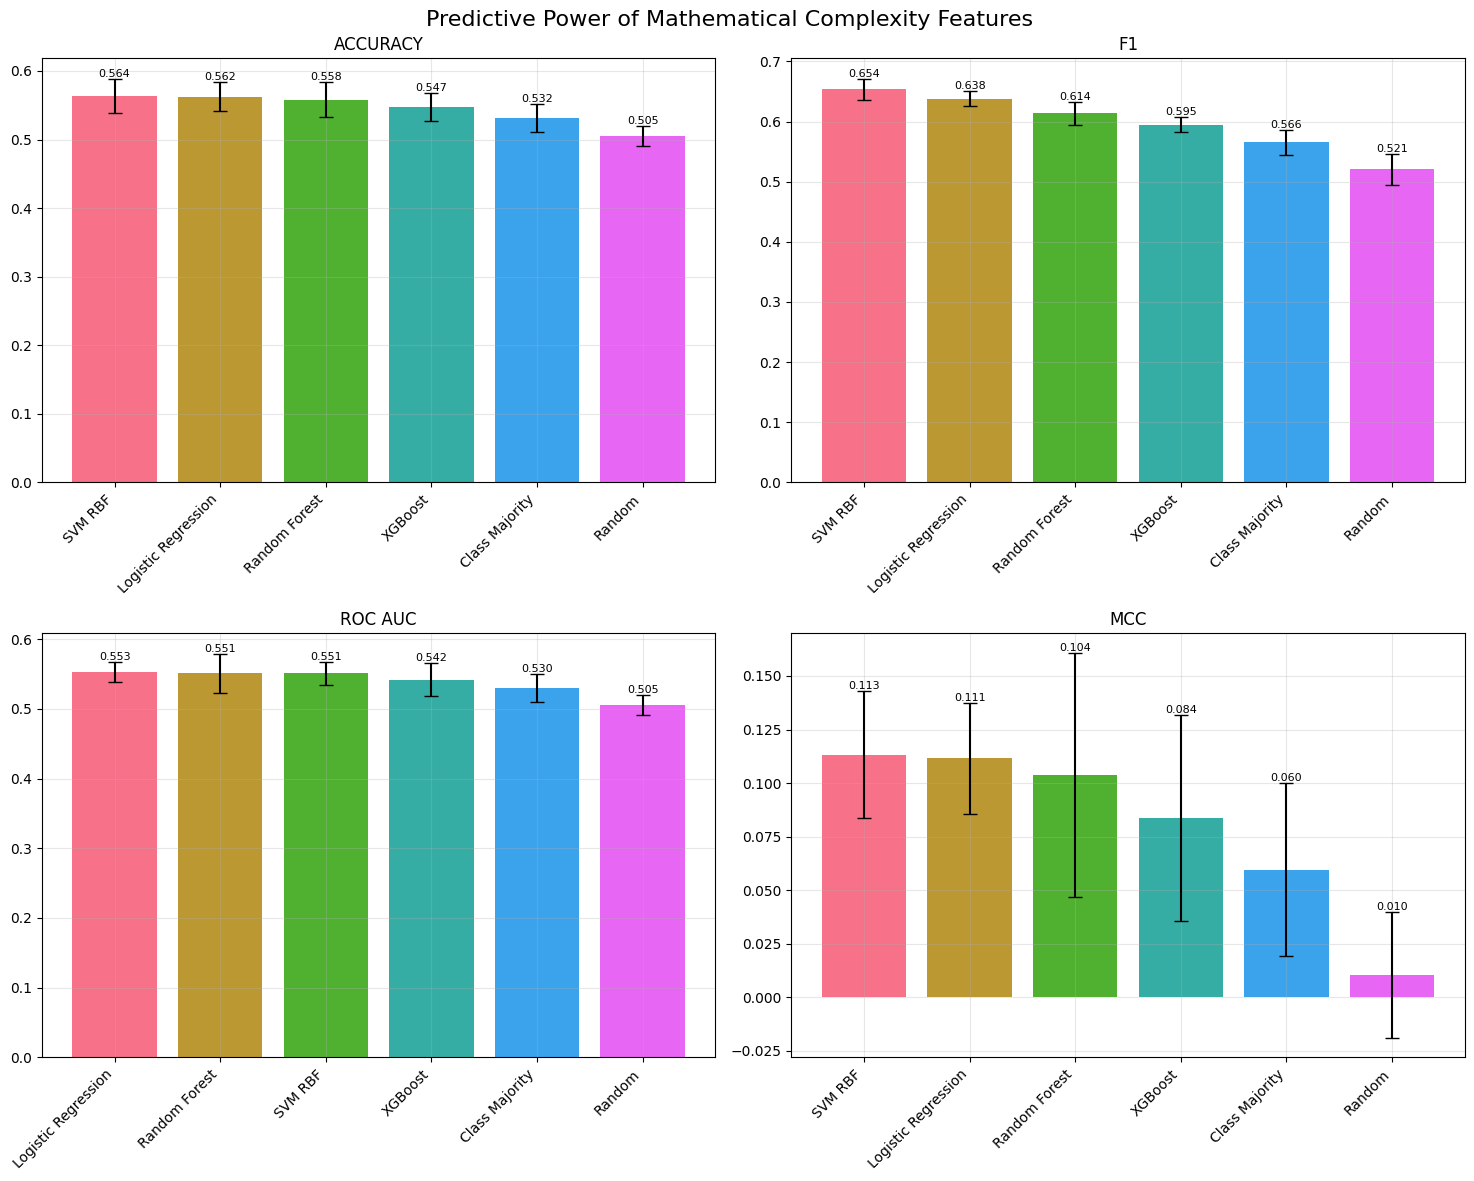

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

def train_and_evaluate_models(X, y, random_state=42, n_runs=5):
    """
    Train and evaluate models to assess predictive power of mathematical complexity features.
    We use multiple models to ensure our conclusions about predictive power are robust.
    """
    models = {
        # Baseline Models
        "Random": DummyClassifier(strategy='uniform', random_state=random_state),
        "Class Majority": DummyClassifier(strategy='stratified', random_state=random_state),
        
        # Prediction Models - each offering a different approach to finding patterns
        "Logistic Regression": LogisticRegression(random_state=random_state),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "SVM RBF": SVC(kernel="rbf", probability=True, random_state=random_state),
        "XGBoost": xgb.XGBClassifier(random_state=random_state)
    }
    
    results = {name: {metric: [] for metric in ['accuracy', 'f1', 'roc_auc', 'mcc']}
              for name in models.keys()}
    
    for i in range(n_runs):
        # Use different random splits to ensure robust performance estimation
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=random_state+i
        )
        
        # Scale features to ensure fair model comparison
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            
            # Store multiple metrics to get a complete picture of predictive power
            results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[name]['f1'].append(f1_score(y_test, y_pred))
            results[name]['roc_auc'].append(roc_auc_score(y_test, y_pred))
            results[name]['mcc'].append(matthews_corrcoef(y_test, y_pred))
    
    return results

def print_model_performance(results):
    """
    Print a formatted table of model performance metrics.
    Includes mean and standard deviation for each metric.
    """
    metrics = ['accuracy', 'f1', 'roc_auc', 'mcc']
    
    # Calculate mean and std for each model and metric
    table_data = []
    for model in results.keys():
        row = [model]
        for metric in metrics:
            mean = np.mean(results[model][metric])
            std = np.std(results[model][metric])
            row.extend([f"{mean:.3f}", f"±{std:.3f}"])
        table_data.append(row)
    
    # Create headers for the table
    headers = ['Model']
    for metric in metrics:
        headers.extend([f'{metric.upper()}', 'STD'])
    
    # Sort table by accuracy (you can modify to sort by different metric)
    table_data.sort(key=lambda x: float(x[1]), reverse=True)
    
    # Print the formatted table
    print("\nModel Performance Metrics:")
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

def plot_model_performance(results):
    """
    Create a clear visualization of model predictive performance.
    Shows all metrics to give a complete picture of how well we can predict acceptance.
    """
    metrics = ['accuracy', 'f1', 'roc_auc', 'mcc']
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # Sort models by performance for clearer visualization
        sorted_models = sorted(results.keys(),
                             key=lambda x: np.mean(results[x][metric]),
                             reverse=True)
        
        means = [np.mean(results[model][metric]) for model in sorted_models]
        stds = [np.std(results[model][metric]) for model in sorted_models]
        
        # Create bars with error bars to show performance stability
        bars = ax.bar(range(len(sorted_models)), means, 
                     yerr=stds, capsize=5,
                     color=sns.color_palette("husl", len(sorted_models)))
        
        ax.set_xticks(range(len(sorted_models)))
        ax.set_xticklabels(sorted_models, rotation=45, ha='right')
        ax.set_title(f'{metric.replace("_", " ").upper()}')
        ax.grid(True, alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(means):
            ax.text(i, v + stds[i], f'{v:.3f}', 
                   ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('Predictive Power of Mathematical Complexity Features', fontsize=16)
    plt.tight_layout()
    return fig

# Run the analysis
results = train_and_evaluate_models(iclr_features, iclr_labels)

# Print tabulated results
print_model_performance(results)

# Visualize results
fig = plot_model_performance(results)
plt.show()

#### Model Performance
- **Best Models**:
 * SVM RBF: Accuracy 0.564 (±0.025), MCC 0.113 (±0.030)
 * Logistic Regression: Accuracy 0.562 (±0.021), MCC 0.111 (±0.026)
 * Random Forest: Accuracy 0.558 (±0.026), MCC 0.104 (±0.057)

#### Performance Analysis
- All models performed similarly, suggesting simple patterns
- Small improvement over random baseline (0.505 ±0.015)
- Consistent performance across multiple metrics
- Low standard deviations indicate stable predictions

### Takeaway 
1. Mathematical complexity has real but modest predictive power
  - ~5-6% improvement over random guessing
  - Consistent across different modeling approaches
  - Stable performance suggests reliable patterns

2. Nature of Relationships
  - Similar performance between linear and non-linear models suggests:
    * Primarily linear relationships
    * Limited complex interactions
    * No hidden patterns missed by simpler models

3. Practical Significance
  - Mathematical complexity alone cannot reliably predict acceptance
  - Supports earlier correlation and interaction analyses
  - Suggests importance of other, unmeasured factors


**NOTE**: Since we are only looking at predictive power correlated features don't pose an issue.

# Conclusion
## Analysis Structure and Flow
Our investigation followed a carefully structured approach to understand the relationship between mathematical complexity and paper acceptance:

1. Initial Correlation Analysis
  We began by examining simple correlations between individual complexity features and acceptance. This provided our first insight that while relationships exist, they are modest in magnitude.

2. Statistical Hypothesis Testing
  We then conducted rigorous statistical tests to verify these relationships, using multiple test types and effect size measurements. This confirmed that the relationships were statistically significant but of small practical significance.

3. Feature Interaction Analysis
  Moving beyond individual features, we investigated how different aspects of mathematical complexity work together. This revealed important interactions, particularly involving equation count and symbol usage patterns.

4. Machine Learning Analysis
  Finally, we used predictive modeling to understand the combined predictive power of all features and validate our earlier findings. This provided a holistic view of how well mathematical complexity predicts acceptance.

This structured approach allowed us to build understanding progressively, with each analysis stage informing and validating the next.

## Key Findings and Conclusions

### The Role of Mathematical Complexity
Our analysis reveals that mathematical complexity plays a subtle but significant role in paper acceptance at ICLR:

1. Direct Effects
  - Individual complexity features show small but consistent correlations with acceptance
  - Number of equations emerged as the strongest single predictor
  - Symbol introduction patterns significantly influence acceptance chances

2. Interactive Effects
  - Strong interactions exist between equation count and symbol usage
  - Papers combining high equation counts with systematic symbol usage show the highest acceptance rates
  - Introducing many new symbols while having few equations correlates with lower acceptance rates

3. Predictive Power
  - Mathematical complexity alone predicts acceptance with modest accuracy (56.4%)
  - The relationship is primarily linear, with limited complex patterns
  - The effect is robust across different statistical approaches